# VIDUS Quality Control Data Processing

**Author:** Jesse Marks

**GitHub Issue**: [#42](https://github.com/RTIInternational/bioinformatics/issues/42)

This notebook documents the steps taken to process the [Vancouver Injection Drug Users Study (VIDUS)](https://www.bccsu.ca/vidus/) data to prepare it for imputation and ultimately a GWAS. VIDUS is one of the longest-running community-recruited prospective cohort studies of people who inject drugs (PWID). These data will be used in the FOU and OAall GWAS for the heroin projects (NGC) as well as HIV acquisition GWAS. 

These data were retrieved from AWS S3: <br>
* `rti-midas-data/studies/vidus/observed/`

Also, the completely unprocessed data are from:

* `s3://rti-midas-data/studies/vidus/observed/unprocessed/Data_Transfer_12SEP2017/Reports/Genotype_Reports/Eric_Johnson_OmniExpress_re-analysis_A1_Manifest_GENOTYPE-REPORT_AUG2017.txt`

## The software and tools needed for this analysis are

* Aspera Connect
* Michigan Imputation Server
* PLINK v1.9
* AWS EC2
* SRA toolkit
* STRUCTURE
* KING

# Phenotype files
TBA

# Genotype Processing
Once converting the data to PLINK format, the genotype processing workflow on the `observed` genotypes is as follows:

1) Remove probe sets that do not have a dbSNP rsID annotation and convert Illumina probe IDs to rsIDs. Remove subjects that do not pass initial phenotype filtering

2) Update genome build and dbSNP build

3) Partition data by ancestry. Subsequent steps are performed by ancestry

4) Remove subjects with data missing for whole autosomes. Subsequent steps up to 16 are performed using autosomes only.

5) Remove duplicates for rsIDs

6) Set genotypes to positive strand orientation

7) Run STRUCTURE to detect and remove subjects that are ancestral outliers

8) Calculate genotype missing call rate. Filter variants with high missing call rates

9) Calculate Hardy-Weinberg (HW) equilibrium for each variant. Filter variants by HW p-values

10) Remove subjects with high missing genotype call rates (as pre-processing for LD pruning)

11) Apply linkage disequilibrium pruning (as pre-processing for steps 12 and 13)

12) Check for sample duplications and monozygotic twins using identical-by-state estimates

13) Check relatedness using identical-by-descent estimates

14) Use KING for calculating IBD for African ancestry subjects

15) Repeat steps 4, 5, 6, 7 (use pre-calculated remove list), 8, and 9 for chrX. Merge autosomes with chrX

16) Remove subjects that meet relatedness filtering criteria

17) Repeat step 10 with all chromosomes

18) Apply linkage disequilibrium pruning (as pre-processing for steps 18 and 19)

19) Remove subjects exhibiting sex discordance

20) Remove subjects exhibiting excessive homozygosity

21) Recode variants in relation to 1000 Genomes phase 3 reference panel. Remove discordant alleles

Many of these steps are done using PLINK commands that update the binary filesets. Generally, each time a new binary fileset is created, text files containing identifiers for what to include or exclude are provided. Consequently, much of the data processing emphasizes creating these text files to be used with PLINK. Note: PLINK has a specific order of operations. Be sure to note this when combining commands and filtering steps.

## Pre-ancestry partitioning quality control sample tracking
The table below provides statistics on variants and subjects filtered during each step of the QC process before partitioning into ancestry groups

**Note**: Initial subject counts are determined by considering only subjects with both genotype and phenotype data available. Consequently, initial numbers may not match between the .fam files and the phenotype files.

| QC procedure                                  | Variants removed | Variants retained | Subjects removed | Subjects retained |
|-----------------------------------------------|------------------|-------------------|------------------|-------------------|
| Initial dbGaP dataset                         |  0               |  713,599          |   0              |  1,014            |
| Remove positive controls                      |  0               |  713,599          |   20             |  994              |
| Genome build 37 & b138 update                 |  1,377           |  712,222          |   0              |  994              |

## European Ancestry
The table below provides statistics on variants and subjects filtered during each step of the QC process.

### Autosome statistics
This table includes filtering statistics prior to merging with chrX.

| QC procedure                                     | Variants removed | Variants retained | Subjects removed | Subjects added | Subjects retained |
|--------------------------------------------------|------------------|-------------------|------------------|-------------|-------------------|
| EA subject filter w/initial procedures (all chr) |  0               |  712,222          |   0              |  0            |   994             |
| Partitioning to only autosomes                   |  19,227          |  692,995          |   0              |  0            |   994             |
| Remove subjects missing whole autosome data      |  0               |  692,995          |  0               |  0           |   994             |
| Add + reassigned subjects based on STRUCTURE     | 0                |  692,995          |  23              |  0           |   972             |
| Remove variants with missing call rate > 3%      |  8,735           |  684,260          | 0                | 0            |  972              |
| Remove variants with HWE p < 0.0001              |  410             |  683,850          | 0                | 0            |  972              |



### ChrX statistics
This table includes filtering statistics prior to merging with autosomes.

| QC procedure                                     | Variants removed | Variants retained | Subjects removed | Subjects added | Subjects retained |
|--------------------------------------------------|------------------|-------------------|------------------|-------------|-------------------|
| EA subject filter w/initial procedures (all chr) | 0                |  712,222          | 0                | 0           |  994              |
| Partitioning to only chrX                        | 694,249          |  17,973           | 0                | 0           |  994              |
| Add + reassigned subjects based on STRUCTURE     | 0                |  17,973           | 23               |  0           |  972              |
| Remove subjects missing whole chrX data          | 0                |  17,973           | 0                | 0           |  972              |
| Remove variants with missing call rate > 3%      | 1,095            |  16,878           | 0                | 0           | 972               |
| Remove variants with HWE p < 0.0001 (applied to females only)              | 1           |  16,877            | 0                | 0           | 972               |

### Merged autosome and chrX statistics

| QC procedure                                     | Variants removed | Variants retained | Subjects removed | Subjects added | Subjects retained |
|--------------------------------------------------|------------------|-------------------|------------------|-------------|-------------------|
| Merge autosomes and chrX                         |  0               | 700,727           | 0                | 0            | 972            |
| Remove subjects with IBD > 0.4 or IBS > 0.9      |  0               | 700,727           | 21               | 0            | 951            |
| Remove subjects with missing call rate > 3%      |  0               | 700,727           | 10               | 0            | 941            |
| Sex discordance filter                           | 0                | 700,727           | 0                | 0            | 941            |
| Excessive homozygosity filter                    | 0                | 700,727           | 0                | 0            | 941            |
| Duplicate variant ID filter after 1000G renaming | 0                | 700,727           | 0                | 0            | 941            |

## Pre-STRUCTURE Analysis
### Convert Data to PLINK (bed/bim/fam) format
Fist convert the data to tped/tfam format, then convert that to bed/bim/fam format.

In [ ]:
## Create directory structure ##

################################################################################
study=vidus
project=hiv
version=004
procD=/shared/jmarks/$project/$study/genotype/observed/processing/$version
mkdir -p $procD
inFile=/shared/jmarks/$project/$study/genotype/observed/unprocessed/Eric_Johnson_OmniExpress_re-analysis_A1_Manifest_GENOTYPE-REPORT_AUG2017.txt
outFile=$procD/prestructure/$study.tped
anlist="ea" # ancestry list (just enter ea if not sure which ancestries groups are in your data)
gcr=0.03 # genotype call-rate threshold filter (typically 0.03 or 0.10)
hwe=0.0001 # hardy weinberg equilibrium threshold (typically 0.0001)
flipFile=/shared/common/chip_info/InfiniumOmniExpress-24v1-2_A1/InfiniumOmniExpress-24v1-2_A1-b37.top_to_plus.flip
################################################################################

In [ ]:
## Create tped file ## (Chr Name 0 Position Allele)
tail -n +2 $inFile |
    perl -ane 'print join("\t", $F[3], $F[1], "0", $F[4]);
                for ( $i = 16; $i < @F; $i += 8) {
                    if ($F[$i] eq "--") {
                        print "\t0\t0";
                    } else {
                        $F[$i] =~ /(\S)(\S)/;
                        print "\t".$1."\t".$2;
                    }
                }
                print "\n";' > $outFile &


## Create tfam file ##
head -n 1 $inFile |
    perl -lne '@F = split(/\t/);
                for ( $i = 10; $i < @F; $i += 8) {
                    $F[$i] =~ s/.GType//;
                    print join("\t", $F[$i], $F[$i], "0\t0\t0\t0");
                }' > \
    $procD/prestructure/$study.tfam &


## Convert to bed/bim/fam ##
/shared/bioinformatics/software/third_party/plink-1.07-x86_64/plink \
    --noweb \
    --tfile $procD/prestructure/$study \
    --make-bed \
    --out $procD/prestructure/$study


## Remove controls ##
grep -P "^POS" $procD/prestructure/$study.fam > \
    $procD/prestructure/controls.remove
/shared/bioinformatics/software/third_party/plink-1.07-x86_64/plink \
    --noweb \
    --bfile $procD/prestructure/$study \
    --remove $procD/prestructure/controls.remove \
    --make-bed \
    --out $procD/prestructure/$study.no_controls

### converting strand to plus strand

In [ ]:
## Flip ##
/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
    --noweb \
    --bfile $procD/prestructure/$study.no_controls \
    --flip $flipFile \
    --make-bed \
    --out $procD/prestructure/$study.no_controls.plus

### Update dbSNP and genome build
To ensure that all of the variant and genomic data are in dbSNP 138 and genome build 37 format, ID and position mappers are used to make data updates.

#### Update to dbSNP138
**Note:** no duplicate SNPs, therefore we will not execute all of the following code, hence the commented code.

In [ ]:
## Update name to dbSNP 138 ##
/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
    --noweb \
    --memory 2048 \
    --bfile $study.no_controls.plus \
    --update-name /shared/common/snp_id_conversion/b138/old_to_current.xref \
    --make-bed \
    --out $study.no_controls.plus.db138

# check for duplicate rsIDs
# Append _X (where X is a number) to the end of the rs IDs for all but 1st occurrence of duplicates
perl -lane 'BEGIN { %idCounts = (); }
                    if (exists($idCounts{$F[1]})) {
                        $idCounts{$F[1]}++;
                        print join("\t",$F[0],$F[1]."_".$idCounts{$F[1]},$F[2],$F[3],$F[4],$F[5]);
                    } else {
                        $idCounts{$F[1]} = 1;
                        print;
                    } ' $study.no_controls.plus.db138.bim > $study.no_controls.plus.db138.renamed.bim

grep -P "_\d" $study.no_controls.plus.db138.renamed.bim | \
    perl -lane 'print substr($F[1], 0, index($F[1],"_"))."\n".$F[1];' \
    > $study.no_controls.plus.db138.renamed.duplicate_snps

wc -l $study.no_controls.plus.db138.renamed.duplicate_snps
"0"

## Get call rates for duplicate SNPs
#/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
#            --bed genotypes_duplicates_removed_rsid_update.bed \
#            --bim genotypes_duplicates_removed_rsid_update_renamed.bim \
#            --fam genotypes_duplicates_removed_rsid_update.fam \
#            --extract genotypes_duplicates_removed_rsid_update_renamed.duplicate_snps \
#            --missing \
#            --out genotypes_duplicates_removed_rsid_update.duplicate_snps.missing
#
## Create remove list for duplicates containing duplicate with higher missing rate
#tail -n +2 genotypes_duplicates_removed_rsid_update.duplicate_snps.missing.lmiss |\
#perl -lane 'BEGIN { %missingness = (); }
#                        if ($F[1] =~ /^(\S+)_/) {
#                            $duplicateName = $1
#                        } else {
#                            $duplicateName = $F[1]."_2";
#                        }
#                        if (exists($missingness{$duplicateName})) {
#                            if ($missingness{$duplicateName} > $F[4]) {
#                                print $duplicateName;
#                            } else {
#                                print $F[1];
#                            }
#                        } else {    
#                            $missingness{$F[1]} = $F[4];
#                        }' > genotypes_duplicates_removed_rsid_update.duplicate_snps.remove
#
## Remove duplicates with higher missing rate
#/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
#   --bed genotypes_duplicates_removed_rsid_update.bed \
#   --bim genotypes_duplicates_removed_rsid_update_renamed.bim \
#   --fam genotypes_duplicates_removed_rsid_update.fam \
#   --exclude genotypes_duplicates_removed_rsid_update.duplicate_snps.remove \
#   --make-bed \
#   --out genotypes_duplicates_removed_rsid_update_duplicates_removed
#
## Remove "_X" from rs IDs
#perl -i.bak -lne 's/_\d\t/\t/; print;'  genotypes_duplicates_removed_rsid_update_duplicates_removed.bim
#

#### Update to genome build (37)
To ensure that all of the population controls have variant and genomic data in dbSNP 138 and genome build 37 format, I use ID and position mappers to make the updates.

In [ ]:
## update to GRCh37 ##
genoData=$procD/prestructure/$study.no_controls.plus.db138

# Update variant chr
/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
    --noweb \
    --memory 2048 \
    --bfile $genoData \
    --update-chr /shared/common/build_conversion/b37/dbsnp_b138/uniquely_mapped_snps.chromosomes \
    --make-bed \
    --out $genoData.chr37

"713599 variants and 994 people pass filters and QC."

# Update variant chr coordinate
/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
    --noweb \
    --memory 2048 \
    --bfile $genoData.chr37 \
    --update-map /shared/common/build_conversion/b37/dbsnp_b138/uniquely_mapped_snps.positions \
    --make-bed \
    --out $genoData.chr37_position37

mkdir $procD/genomewide
# Filter to only build 37 uniquely mapped variants
/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
    --noweb \
    --memory 2048 \
    --bfile $genoData.chr37_position37 \
    --extract /shared/common/build_conversion/b37/dbsnp_b138/uniquely_mapped_snps.ids \
    --make-bed \
    --out $procD/prestructure/genomewide/$study.dbsnp138.b37

### Ancestry partitioning
Since we do not have any phenotype information about the subjects, we will treat all of the subjects as EA subjects until after we perform the Structure analysis.

In [ ]:
for an in $anlist;do
    mkdir $procD/$an
    cp $procD/genomewide/$study.dbsnp138.b37* $procD/$an
done

### code below was from another study but we will not have to use in this case.

## Construct a subject ID list for each ancestry group
#tail -n +12 ../../../phenotype/processing/Subject_Phenotypes.DS-ADX-IRB-NPU.txt | \
#    awk '{ FS="\t"; OFS="\t" } { if($5=="African_American"){print 0,$2} }' >  ../../../phenotype/processing/aa_subject_ids.txt
#
#tail -n +12 ../../../phenotype/processing/Subject_Phenotypes.DS-ADX-IRB-NPU.txt | \
#    awk '{ FS="\t"; OFS="\t" } { if($5=="Hispanic"){print 0,$2} }' > ../../../phenotype/processing/ha_subject_ids.txt
#
#tail -n +12 ../../../phenotype/processing/Subject_Phenotypes.DS-ADX-IRB-NPU.txt | \
#    awk '{ FS="\t"; OFS="\t" } { if($5=="White"){print 0,$2} }' > ../../../phenotype/processing/ea_subject_ids.txt
#
## Make new binary filesets for each ancestry group
#for ancestry in {aa,ha,ea}; do
#    echo -e "\n\n ================ ${ancestry} ================\n\n"
#    mkdir ${ancestry}
#    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
#      --bfile genotypes_b37_dbsnp138 \
#      --keep ../../../phenotype/processing/${ancestry}_subject_ids.txt \
#      --make-bed \
#      --out ${ancestry}/genotypes_b37_dbsnp138
#done


### Partition into autosome and chrX groups
I apply QC to autosomes and chrX separately, so separate subdirectories are created for the processing of each set.

In [ ]:
## Autosome + chrX paritioning ##
# Autosomes
/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
    --bfile $procD/prestructure/genomewide/$study.dbsnp138.b37 \
    --autosome \
    --make-bed \
    --out $procD/prestructure/autosomes/$study.dbsnp138.b37

# ChrX
/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
    --bfile $procD/prestructure/genomewide/$study.dbsnp138.b37 \
    --chr 23 \
    --make-bed \
    --out $procD/prestructure/chrX/$study.dbsnp138.b37

```
wc -l */*/*bim
 692995 autosomes/vidus.genotypes_b37_dbsnp138.bim
   17542 chrX/vidus.genotypes_b37_dbsnp138.bim
```

### Missing autosome data subject filtering
We calculate the proportion of missing genotype calls per chromosome using PLINK to assess whether any subjects have data missing for whole autosomes.

In [ ]:
## missing autosome data subject filtering ##
for chr in {1..22}; do
    /shared/bioinformatics/software/scripts/qsub_job.sh \
        --job_name chr${chr}_test \
        --script_prefix $procD/prestructure/autosomes/chr${chr}_missing_call_rate \
        --mem 3.8 \
        --priority 0 \
        --program /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
            --noweb \
            --bfile $procD/prestructure/autosomes/$study.dbsnp138.b37 \
            --missing \
            --chr $chr \
            --out $procD/prestructure/autosomes/chr${chr}_missing_call_rate
done

# none missing whole autosome data
rm $procD/prestructure/autosomes/chr*missing_call_rate*

For this case none of the ancestry groups had subjects with missing autosome data. If subjects ever show up as having missing autosome data then further discussions need to be had on whether these subjects should be removed completely or whether they should only be excluded for the missing chromosomes.

##  STRUCTURE Analysis—Detecting ancestral outliears 
[STRUCTURE](https://web.stanford.edu/group/pritchardlab/structure.html) is a software tool that can be used to identify admixed individuals, among other uses. By comparing the study subjects with reference panel populations such as HapMap or 1000 Genomes, we can estimate the composition of an individual's ancestry to determine any discrepancies between self-reporting and genetic information. For this study data, we will be comparing the individuals to 3 different superpopulations from the 1000 Genomes Phase 3 reference panel

* AFR (African)
* EAS (East Asian)
* EUR (European)

**SNP subset selection**
For computational efficiency 10,000 SNPs are randomly chosen from the intersection of SNPs in the study data with the 3 1000 Genomes superpopulations of interest. As of 10/09/2017 the binary filesets per chromosome in PLINK format for 1000G Phase 3 can be found in 
`/shared/data/ref_panels/1000G/2013.05/plink`. According to the [1000 Genomes paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4750478/).

**NOTE:** The location `/shared/data/ref_panels/1000G/2014.10/1000GP_Phase3` also contatins 1000G phase 3 data derived from the May 2013 release. The difference is that it was downloaded from the [IMPUTE2 website](https://mathgen.stats.ox.ac.uk/impute/1000GP_Phase3.html) and reformatted to be directly compatible with IMPUTE2.

In [ ]:
## STRUCTURE ##
mkdir -p $procD/structure

# Get lists of non-A/T and non-C/G SNPs
perl -lane 'if (($F[4] eq "A" && $F[5] ne "T") || ($F[4] eq "T" && $F[5] ne "A") || ($F[4] eq "C" && $F[5] ne "G") || ($F[4] eq "G" && $F[5] ne "C")) { print $F[1]; }' \
    $procD/prestructure/autosomes/$study.dbsnp138.b37.bim | \
    sort -u | \
    grep "rs" > $procD/structure/${study}.no_at_cg_snps.txt

## Get rsID overlap between study data ancestry groups
#comm -12 <(comm -12 structure/aa_no_at_cg_snps.txt structure/ea_no_at_cg_snps.txt) structure/ha_no_at_cg_snps.txt | \
#sort > structure/aa_ea_ha_shared_snps.txt
#
#wc -l structure/aa_ea_ha_shared_snps.txt
#"""476061 structure/aa_ea_ha_shared_snps.txt"""
#
wc -l $procD/structure/vidus.no_at_cg_snps.txt
"""
678704 structure/vidus.no_at_cg_snps.txt
"""


# Get list of variants from 1000G
mkdir $procD/structure/1000g_data
/shared/bioinformatics/software/scripts/qsub_job.sh \
    --job_name merge_1000g_snps \
    --script_prefix $procD/structure/1000g_data/merge_1000g_snps \
    --mem 3 \
    --priority 0 \
    --program "cut -f2,2 /shared/data/ref_panels/1000G/2013.05/plink/ALL.chr{1..22}.bim | \
        grep \"rs\" | \
        sort -u > $procD/structure/1000g_data/1000g_phase3_snps.txt"

# This should always be 79,873,045
wc -l $procD/structure/1000g_data/1000g_phase3_snps.txt
"""
79873045 structure/1000g_data/1000g_phase3_snps.txt
"""

# Get SNP overlap between study data and 1000G
comm -12 $procD/structure/${study}.no_at_cg_snps.txt $procD/structure/1000g_data/1000g_phase3_snps.txt >\
    $procD/structure/${study}.1000g_shared_snps.txt

wc -l $procD/structure/${study}_1000g_shared_snps.txt 
"""
662917 /shared/jmarks/heroin/vidus/genotype/observed/processing/003/structure/vidus_1000g_shared_snps.txt
"""

# Select 10,000 random SNPs from study and 1000G overlap
perl -ne 'print rand()."\t".$_' $procD/structure/${study}.1000g_shared_snps.txt | \
    sort -k1,1 | \
    head -10000 | \
    cut -f2,2 \
    > $procD/structure/10k_snp_random_sample.txt &

### Extract SNP subset PLINK binary filesets for Study data

In [ ]:
## EC2 console ##

# Create ped and map files for study genotype data for SNP subset
#for ancestry in $anlist; do
/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
    --noweb \
    --bfile $procD/prestructure/autosomes/$study.dbsnp138.b37 \
    --extract $procD/structure/10k_snp_random_sample.txt \
    --snps-only just-acgt \
    --recode \
    --out $procD/structure/${study}.10k_snp_random_sample
#done

### Extract SNP subset PLINK binary filesets for 1000G data

The 05/2013 release of the 1000 Genomes data have been previously processed and converted to PLINK binary fileset format, but the files include all the 1000G individuals. We are interested in only four superpopulations, so we create filesets specifically for each of these groups. It was brought to my attention that 1000G Phase 3 rsIDs may be duplicated across chromosomes potentially causing chromosome merging issues. For that reason, it is typically recommended to process the chromosomes separately initially, then combine post SNP subsetting. Subject IDs with superpopulation classifications are available at:

`/shared/data/ref_panels/1000G/igsr_samples.tsv`

In [ ]:
# Ancestry specific directories
for pop in {AFR,EAS,EUR}; do
    mkdir $procD/structure/1000g_data/${pop}
done

# Get subject IDs by ancestry
awk 'BEGIN { FS="\t"; OFS="\t" } { if($7=="African"){print $1,$1} }' /shared/data/ref_panels/1000G/2013.05/igsr_samples.tsv \
    > $procD/structure/1000g_data/AFR/AFR_subject_ids.txt
awk 'BEGIN { FS="\t"; OFS="\t" } { if($7=="East Asian"){print $1,$1} }' /shared/data/ref_panels/1000G/2013.05/igsr_samples.tsv \
    > $procD/structure/1000g_data/EAS/EAS_subject_ids.txt
awk 'BEGIN { FS="\t"; OFS="\t" } { if($7=="European"){print $1,$1} }' /shared/data/ref_panels/1000G/2013.05/igsr_samples.tsv \
    > $procD/structure/1000g_data/EUR/EUR_subject_ids.txt

# Make new binary filesets for each 1000G group
# only keeping the data from individuals which are from 1 of the three super populations
for pop in {AFR,EAS,EUR}; do
    for chr in {1..22}; do
        /shared/bioinformatics/software/scripts/qsub_job.sh \
            --job_name ${pop}_${chr}_filter \
            --script_prefix $procD/structure/1000g_data/${pop}/ancestry_partition_chr${chr} \
            --mem 15.5 \
            --priority 0 \
            --program /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink  \
                --noweb \
                --memory 10000 \
                --bfile /shared/data/ref_panels/1000G/2013.05/plink/ALL.chr${chr} \
                --keep $procD/structure/1000g_data/${pop}/${pop}_subject_ids.txt \
                --extract $procD/structure/10k_snp_random_sample.txt \
                --make-bed \
                --out $procD/structure/1000g_data/${pop}/${pop}_chr${chr}_10k_snp_random_sample
    done
done

In [ ]:
# Create merge lists and merge autosomes for each 1000G population
data_dir=$procD/structure/1000g_data
for pop in {AFR,EAS,EUR}; do
    echo "${data_dir}/${pop}/${pop}_chr1_10k_snp_random_sample" > ${data_dir}/${pop}/${pop}_autosome_merge_list.txt
    for chr in {2..22}; do
        echo "${data_dir}/${pop}/${pop}_chr${chr}_10k_snp_random_sample" \
        >> ${data_dir}/${pop}/${pop}_autosome_merge_list.txt
    done
done

for pop in {AFR,EAS,EUR}; do
    /shared/bioinformatics/software/scripts/qsub_job.sh \
        --job_name ${pop}_merge_plink_filesets \
        --script_prefix $procD/structure/1000g_data/${pop}/merge_plink_filesets \
        --mem 4 \
        --priority 0 \
        --program /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
            --noweb \
            --memory 4000 \
            --merge-list $procD/structure/1000g_data/${pop}/${pop}_autosome_merge_list.txt \
            --snps-only just-acgt \
            --make-bed \
            --out $procD/structure/1000g_data/${pop}/${pop}_all_autosomes_10k_snp_random_sample
done

### Discrepancy assessment between Study and 1000G data
As a quality check that the SNP data subsampled from the study data and 1000 Genomes data are the same, I will attempt to merge an arbitrarily selected group from each data set using PLINK. If any errors are found, PLINK will generate an error file. Likely causes of errors would be:

* SNP genomic coordinates not matching
* SNP duplicates found
* SNP strand orientation flipped

If errors are found the two options for moving forward are

1. Re-run the 10,000 SNP subsampling and hope the SNPs chosen do not raise issues
2. Remove the problematic SNPs
Option #2 is the prefered approach and the one I will be taking.

In [ ]:
## EC2 console ##

ancestry="ea"
# Merge EA and EUR genotype files
# --merge-mode 7 (no merge) Report mismatching nonmissing calls.
/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
    --noweb \
    --file $procD/structure/${study}.10k_snp_random_sample \
    --bmerge $procD/structure/1000g_data/EUR/EUR_all_autosomes_10k_snp_random_sample \
    --merge-mode 7 \
    --out $procD/structure/1000g_EUR_${study}_${ancestry}_10k_snp_random_sample


## 1 is for the header
#    wc -l $procD/structure/*diff
#"""
#1 /shared/data/studies/heroin/uhs4/genotype/observed/processing/002/structure/1000g_EUR_uhs4_ea_10k_snp_random_sample.diff
#"""

### STRUCTURE input file construction

In [ ]:
## EC2 console ##

# Create final ped and map files for study genotype data for SNP subset
ancestry=ea
/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
    --noweb \
    --memory 3000 \
    --bfile $procD/prestructure/autosomes/$study.dbsnp138.b37 \
    --extract $procD/structure/10k_snp_random_sample.txt \
    --snps-only just-acgt \
    --recode \
    --out $procD/structure/${ancestry}_10k_snp_random_sample.final

# Create ped and map files for each 1000G population
for pop in {AFR,EAS,EUR}; do
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --memory 1024 \
        --bfile $procD/structure/1000g_data/${pop}/${pop}_all_autosomes_10k_snp_random_sample \
        --recode \
        --out $procD/structure/1000g_data/${pop}_10k_snp_random_sample.final
done


# Final check for SNP discrepancies
/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
    --noweb \
    --file $procD/structure/ea_10k_snp_random_sample.final \
    --merge $procD/structure/1000g_data/EUR_10k_snp_random_sample.final \
    --recode \
    --out $procD/structure/structure_input_test


wc -l  $procD/structure_input_test*.map
"""
9999 /shared/jmarks/heroin/vidus/genotype/observed/processing/002/structure_input_test.map
"""

No merging issues were identified in the final check, so I will use the script ped2structure.pl to convert the PED file into a STRUCTURE input file format. This script takes two inputs. The first is an integer that serves as an ID to distinguish between a reference panel population or a study data set group. The second input is an integer that is unique to each group/population regardless of whether it's from the study or 1000G data.

The goal of the conversion script is to generate a single STRUCTURE input file containing genotype information for the ~10,000 (post-filtered) subsampled SNPs and the individuals from the study and 1000G data sets. Documentation on the format can be found [here](https://web.stanford.edu/group/pritchardlab/structure_software/release_versions/v2.3.4/structure_doc.pdf). The first three columns contatin the following information respectively

1. Subject identifier
2. Group/population identifier. Distinct for each ancestry group or superpopulation
3. Boolean indicator (1=True, 0=False) specifying reference panel populations. This is used by STRUCTURE to define the ancestry groups

We will be running structure assuming that the study subjects descended from three populations. The traditional approach would be to use AFR, EAS, and EUR. I will run STRUCTURE using these 1000G superpopulations.

Note: for $K$ reference panel populations used for ancestry comparisons, the reference panel populations must be given group IDs between 1 and $K$.

In [ ]:
## EC2 console ##
mkdir $procD/structure/input_files

groupID=1 #distinguish between all groups

# Append 1000G populations to STRUCTURE file
truncate -s 0 $procD/structure/input_files/input_afr_eas_eur
for pop in {AFR,EAS,EUR}; do
    cat $procD/structure/1000g_data/${pop}_10k_snp_random_sample.final.ped | \
    /shared/bioinformatics/software/perl/file_conversion/ped2structure.pl 1 ${groupID} \
    >> $procD/structure/input_files/input_afr_eas_eur
    groupID=`echo ${groupID} + 1 | bc`
done

# Append remaining ancestry groups to STRUCTURE file
for ancestry in $anlist; do
    cat $procD/structure/${ancestry}_10k_snp_random_sample.final.ped | \
    /shared/bioinformatics/software/perl/file_conversion/ped2structure.pl 0 ${groupID} \
    >> $procD/structure/input_files/input_afr_eas_eur
    groupID=`echo ${groupID} + 1 | bc` 
done

### Run STRUCTURE
For running STRUCTURE, the following command line parameters are explicitly specified

* m - Main parameter file
* e - Additional parameter file
* i - Input data file
* o - Output file
* L - Number of loci in data file
* N - Number of subjects
* K - Maximum number of populations

The remaining parameters are specified in the mainparams and extraparams files. Any values specified on the command-line override the values in the configuration files. Documentation on the parameter options can be found [here](https://web.stanford.edu/group/pritchardlab/structure_software/release_versions/v2.3.4/structure_doc.pdf).

Because I am using combinations of three from the four 1000G superpopulations, I will run STRUCTURE for each of these combinations.

In [ ]:
## EC2 console ##

mkdir $procD/structure/output_files
ancestry=ea

# Run Structure using AFR, EAS, and EUR
# Why add the random number generator flag?
L=$(wc -l $procD/structure/${ancestry}_10k_snp_random_sample.final.map | perl -lane 'print $F[0];')
N=$(wc -l $procD/structure/input_files/input_afr_eas_eur | perl -lane 'print $F[0]/2;')
sh /shared/bioinformatics/software/scripts/qsub_job.sh \
    --job_name structure_afr_eas_eur \
    --script_prefix $procD/structure/output_files/structure_afr_eas_eur \
    --mem 15 \
    --nslots 4 \
    --priority 0 \
    --program /shared/bioinformatics/software/third_party/structure_v2.3.4/console/structure \
         -m /shared/bioinformatics/software/third_party/structure_v2.3.4/console/mainparams \
         -e /shared/bioinformatics/software/third_party/structure_v2.3.4/console/extraparams \
         -i $procD/structure/input_files/input_afr_eas_eur \
         -o $procD/structure/output_files/output_afr_eas_eur \
         -L $L \
         -N $N \
         -K 3 
         #-D 1523031945

### Producing triangle plots
[Triangle or ternary plots](https://en.wikipedia.org/wiki/Ternary_plot) provide a means to visualize membership strength. For the purposes of the Kreek data, the triangle plots are used to determine how similar self-reports of individuals from a Kreek ancestry group are to three disparate reference populations. The visualizations allow for the identification of potential outliers that would be removed from downstream processing and analysis.

**Note**: The command line Perl script below assumes a specific order of the STRUCTURE output data in regards to the group IDs. Modifications should be made as necessary to ensure that the labels match with the ID. Additionally, `triangle_plot.R` does not check that the cluster specifications match the given 1000G superpopulation labels. Be sure to assign the right label to the right group ID from previous processing steps.

In [ ]:
## EC2 console ##
mkdir $procD/structure/triangle_plots

#### AFR, EAS, and EUR ####

# Prepare results for triangle plot
# note to change @datasets to reflect current study
STUDY=${study^^}
export STUDY
perl -ne 'if (/%Miss/) {
              $in=1;
              print "num\tID\tpop\tcluster1\tcluster2\tcluster3\n";
          }
          if ($in==1 && !/Label/ && !/^\s+$/) {
              @datasets=("AFR","EAS","EUR", $ENV{STUDY});
              s/^\s+//g;
              @F=split /\s+/;
              # Grab only study groups by ID
              if ($F[3] > 3) {
                  print $F[0]."\t".$F[1]."\t".$datasets[$F[3]-1]."\t".$F[5]."\t".$F[6]."\t".$F[7]."\n";
              }
          } 
          s/\s+//g;
          if ($_ eq "") { $in=0; }' $procD/structure/output_files/output_afr_eas_eur_f > \
    $procD/structure/triangle_plots/afr_eas_eur.triangle_input

# Prepare id xref file (cross reference file)
perl -ne 'if ($count==0) { print "num\tID\n"; }
          if (!defined $even) { print STDERR "LALALA\n";} 
          if ($even==0) {/^(\S+)/; print $count+1; print "\t".$1."\n"; $count++; $even=1}
          else {$even=0}' $procD/structure/input_files/input_afr_eas_eur > \
    $procD/structure/triangle_plots/afr_eas_eur_id_xref

# Generate triangle plot 
Rscript /shared/bioinformatics/software/R/triangle_plot.R \
    --data $procD/structure/triangle_plots/afr_eas_eur.triangle_input \
    --prefix $procD/structure/triangle_plots/afr_eas_eur \
    --cluster1 African \
    --cluster2 Asian \
    --cluster3 European \
    --xref $procD/structure/triangle_plots/afr_eas_eur_id_xref

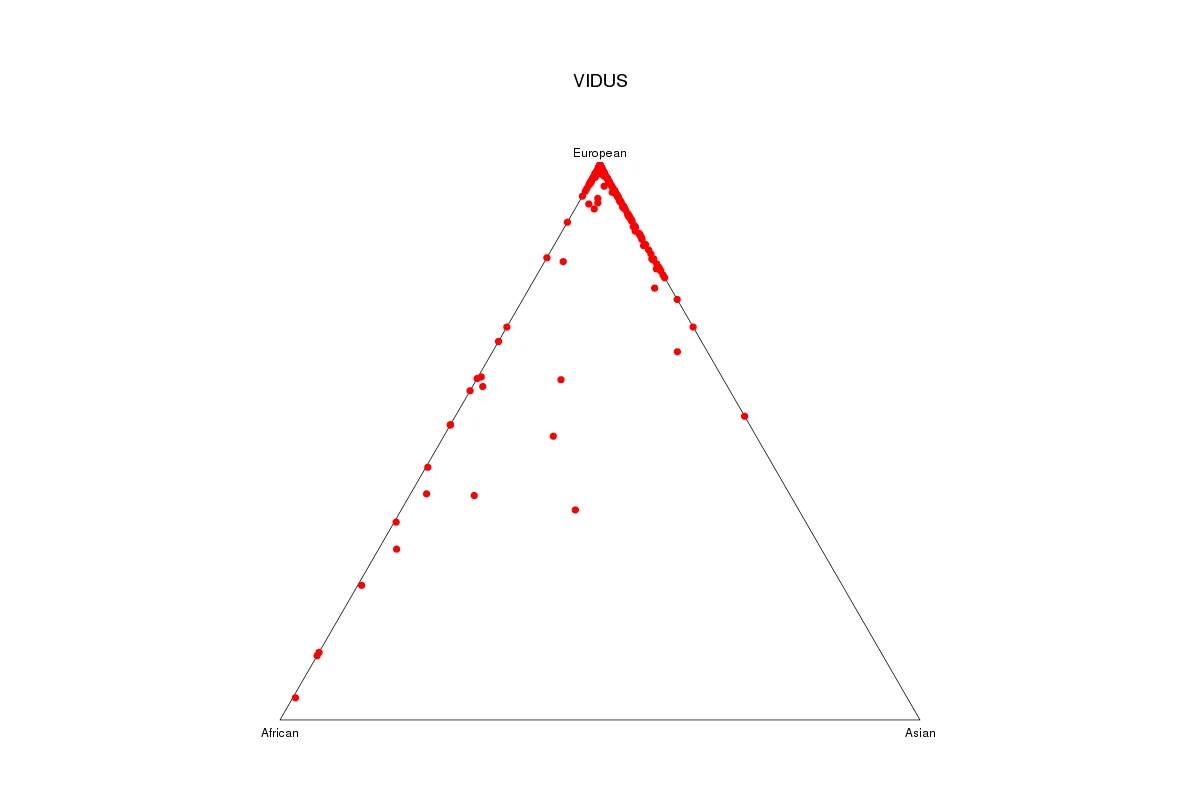

In [4]:
## R console ##
library("IRdisplay")
display_png(file="/Users/jmarks/OneDrive - Research Triangle Institute/Projects/heroin/ngc/vidus/qc/afr_eas_eur_VIDUS.jpg", width=800, height=800)

#### Reassigning and removing outliers
The following retainment thresholds should be implemented:


| Action Description | Thresholding Criteria      |
|--------------------|----------------------------|
| For EA retainment | (AFR < 25%)$ \wedge $(EAS < 25%) |
| For AA retainment | (AFR > 25%)$ \wedge $(EAS < 25%) |
| For HA retainment | (AFR < 25%)$ \wedge $(EAS > 25%) |


**Note:** there are no self-report data at this time. There will be once the phenotype file has been constructed.

Subject counts after applying the filters above.
```
wc -l *filtered
   18 aa_filtered
  972 ea_filtered
    3 ha_filtered
993 total
```
Note that one subject was not assigned to any ancestry group:
```
num     ID      pop     cluster1        cluster2        cluster3
2211    8005964970_     VIDUS   0.341   0.284   0.375
```

In [ ]:
## EC2 command line
### get details on which subjects are reassigned ###

plots=$procD/structure/triangle_plots/no_self
mkdir -p $plots

cp $procD/structure/triangle_plots/afr_eas_eur.triangle_input $plots/

# AA retained
#--------------------------------------------------------------------------------
# Create triangle plot input with potential outliers filtered
eth=AA

head -1 $procD/structure/triangle_plots/afr_eas_eur.triangle_input > \
    $plots/afr_eas_eur_filtered.triangle_input

tail -n +2 $plots/afr_eas_eur.triangle_input | \
    perl -lane 'if (($F[3] > 0.25 && $F[4] < 0.25)) { print $_ }' \
    > $plots/aa_filtered

# study=vidus, for example
awk -v study="$study" -v eth="$eth" 'BEGIN{OFS="\t"} {$3=study "_" eth;print $0}' $plots/aa_filtered >> $plots/afr_eas_eur_filtered.triangle_input


# EA retained
#--------------------------------------------------------------------------------
# Create triangle plot input with potential outliers filtered
eth=EA

tail -n +2 $plots/afr_eas_eur.triangle_input |\
    perl -lane 'if (($F[3] < 0.25 && $F[4] < 0.25)) { print $_; }' \
    > $plots/ea_filtered
awk -v study="$study" -v eth="$eth" 'BEGIN{OFS="\t"} {$3=study "_" eth;print $0}' $plots/ea_filtered >> $plots/afr_eas_eur_filtered.triangle_input
#--------------------------------------------------------------------------------

# HA retained
#--------------------------------------------------------------------------------
# Create triangle plot input with potential outliers filtered
eth=HA

tail -n +2 $plots/afr_eas_eur.triangle_input |\
    perl -lane 'if (($F[3] < 0.25 && $F[4] > 0.25)) { print $_; }' \
    > $plots/ha_filtered
awk -v study="$study" -v eth="$eth" 'BEGIN{OFS="\t"} {$3=study "_" eth;print $0}' $plots/ha_filtered >> $plots/afr_eas_eur_filtered.triangle_input
#--------------------------------------------------------------------------------

# subjects not assigned to any ancestry group
grep -v -f <(cat *filtered) ../afr_eas_eur.triangle_input > no_assignment_filtered
"""
num     ID      pop     cluster1        cluster2        cluster3
2211    8005964970_     VIDUS   0.341   0.284   0.375
"""

# Generate filtered triangle plot
Rscript /shared/bioinformatics/software/R/triangle_plot.R \
    --data $plots/afr_eas_eur_filtered.triangle_input \
    --prefix $plots/afr_eas_eur_filtered \
    --cluster1 African \
    --cluster2 Asian \
    --cluster3 European \
    --xref $procD/structure/triangle_plots/afr_eas_eur_id_xref

#### Filtered results

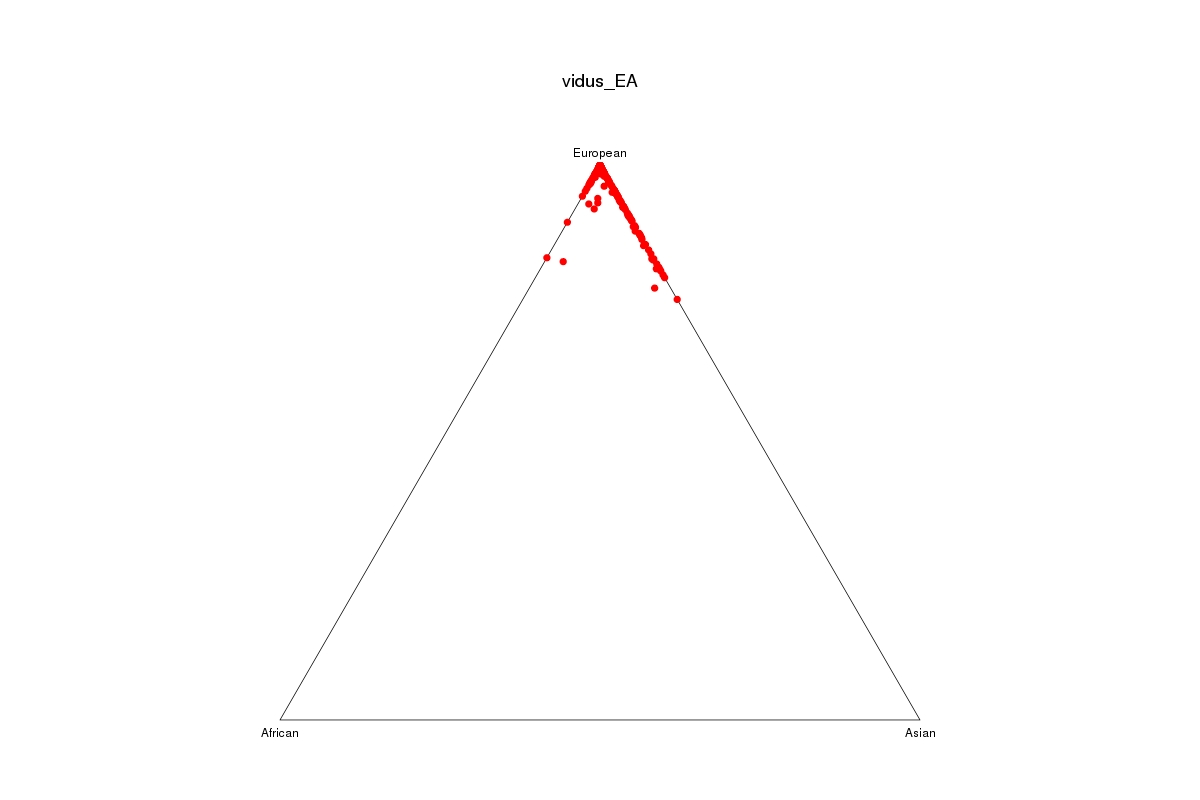

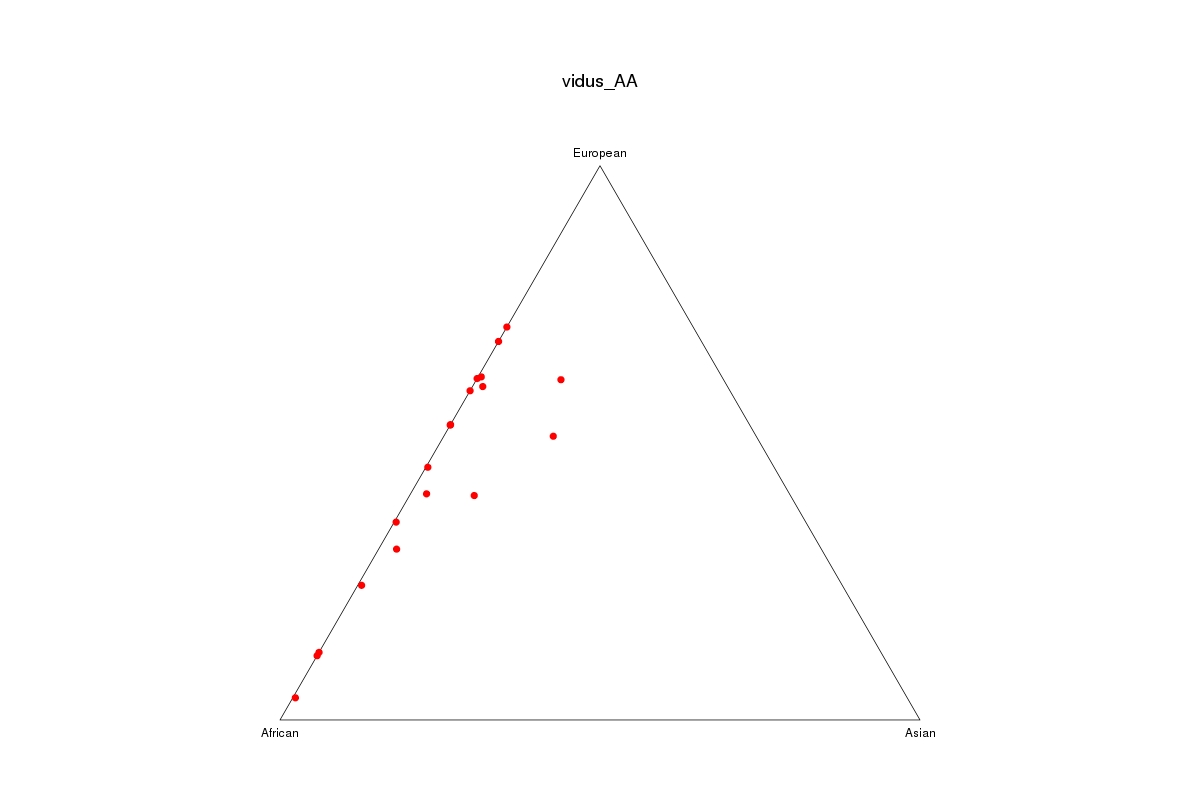

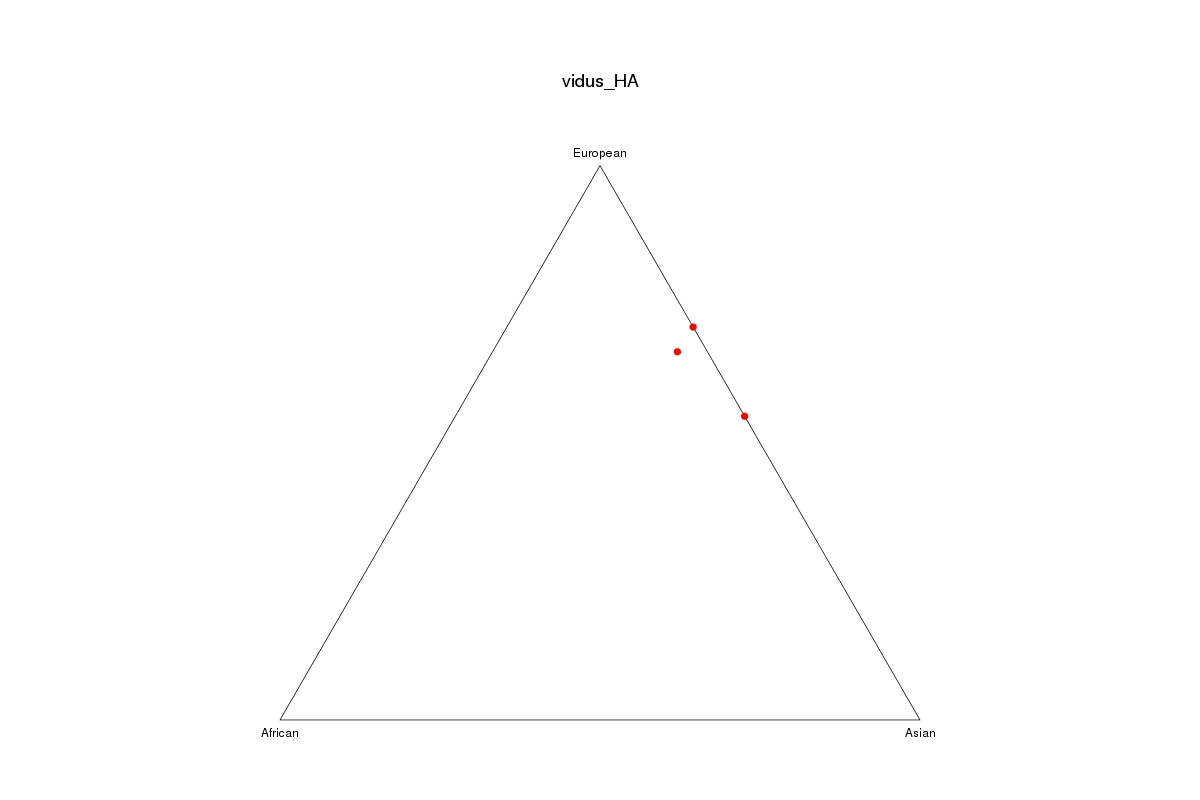

In [7]:
## R console ##
library("IRdisplay")
display_png(file="/Users/jmarks/OneDrive - Research Triangle Institute/Projects/heroin/ngc/vidus/qc/afr_eas_eur_filtered_vidus_EA.jpg", width=800, height=800)
display_png(file="C:/Users/jmarks/OneDrive - Research Triangle Institute/Projects/heroin/ngc/vidus/qc/afr_eas_eur_filtered_vidus_AA.jpg", width=800, height=800)
display_png(file="C:/Users/jmarks/OneDrive - Research Triangle Institute/Projects/heroin/ngc/vidus/qc/afr_eas_eur_filtered_vidus_HA.jpg", width=800, height=800)

Because there are only 3 HA subjects  and 18 AA subjects left after applying the ancestral thresholds for filtering, we will proceed with only the EAs. 

## Post-Structure
### Create updated PLINK filesets

In [ ]:
## EC2 command line
#procD=/shared/jmarks/heroin/vidus/genotype/observed/processing/002
plots=$procD/structure/triangle_plots/no_self
anlist="ea"


# clean up previous processing 
rm -rf $procD/{aa,ea,ha}/{autosomes,chrX}
rm $procD/{aa,ea,ha}/chr*flipped*

# create directory structure
for ancestry in $anlist;do
    mkdir -p $procD/$ancestry/{autosomes,chrX}
done

# get ancestry counts after filtering + create a keepIDs list
for an in $anlist;do
    awk -v an="${an^^}" -v study="$study" '$3==study"_"an {print $2}' \
        $plots/afr_eas_eur_filtered_for_filtering.txt > $procD/$an/subject_ids.keep
    wc -l $procD/$an/subject_ids.keep
done
"""
972 /shared/jmarks/heroin/vidus/genotype/observed/processing/004/ea/subject_ids.keep
"""

# split famID_IID up by tab --> famID"\t"IID
for an in $anlist;do
    while read line;do
        half=$(expr ${#line} / 2)
        echo ${line:0:$half} ${line:0:$half}
    done < $procD/$an/subject_ids.keep > $procD/$an/subject_ids.keep.txt
done

for ancestry in $anlist; do
    echo -e "\n\n======== ${ancestry} ========\n\n"
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --memory 5000 \
        --bfile $procD/prestructure/genomewide/$study.dbsnp138.b37 \
        --keep $procD/${ancestry}/subject_ids.keep.txt \
        --make-bed \
        --out $procD/${ancestry}/$study.dbsnp138.b37.structure
done

for an in $anlist; do
    wc -l $procD/$an/*{bim,fam}
done
            
"""
  712222 /shared/jmarks/heroin/vidus/genotype/observed/processing/004/ea/vidus.dbsnp138.b37.structure.bim
     972 /shared/jmarks/heroin/vidus/genotype/observed/processing/004/ea/vidus.dbsnp138.b37.structure.fam
"""

In [ ]:
## EC2 command line

# Create autosome and chrX file sets
for ancestry in $anlist; do
    echo -e "\n\n======== ${ancestry} ========\n\n"
    mkdir $procD/${ancestry}/{chrX,autosomes}

    # Autosomes
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --memory 5000 \
        --bfile $procD/${ancestry}/$study.dbsnp138.b37.structure \
        --autosome \
        --make-bed \
        --out $procD/${ancestry}/autosomes/$study.dbsnp138.b37.structure

    # ChrX (include split PARs)
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --memory 5000 \
        --bfile $procD/${ancestry}/$study.dbsnp138.b37.structure \
        --chr 23,25 \
        --make-bed \
        --out $procD/${ancestry}/chrX/$study.dbsnp138.b37.structure.unmerged

    # Combine split chrX and PARs
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --memory 5000 \
        --bfile $procD/${ancestry}/chrX/$study.dbsnp138.b37.structure.unmerged \
        --merge-x \
        --make-bed \
        --out $procD/${ancestry}/chrX/$study.dbsnp138.b37.structure
done

## get counts
for an in $anlist;do
    wc -l $procD/$an/{chrX,autosomes}/*structure.bim
done
"""
   17973 /shared/jmarks/heroin/vidus/genotype/observed/processing/004/ea/chrX/vidus.dbsnp138.b37.structure.bim
  692995 /shared/jmarks/heroin/vidus/genotype/observed/processing/004/ea/autosomes/vidus.dbsnp138.b37.structure.bim
"""

### Autosome Processing
#### Genotype call rate variant filter
I calculate the genotype missing call rate and remove any variants with a rate >3%.

In [ ]:
## EC2 command line

## Genotype call rate variant filter
for ancestry in $anlist; do
    echo -e "\n\n================ ${ancestry} ================\n\n"
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --memory 5000 \
        --bfile $procD/${ancestry}/autosomes/$study.dbsnp138.b37.structure \
        --geno $gcr \
        --make-bed \
        --out $procD/${ancestry}/autosomes/$study.dbsnp138.b37.structure.variant_missing_lte_${gcr}_filter
done

for an in $anlist;do
    wc -l $procD/${ancestry}/autosomes/$study.dbsnp138.b37.structure.variant_missing_lte_${gcr}_filter*bim
done
"""
684260 /shared/jmarks/heroin/vidus/genotype/observed/processing/004/ea/autosomes/vidus.dbsnp138.b37.structure.variant_missing_lte_0.03_filter.bim
"""


#### Hardy-Weinberg equilibrium filtering
Extensive deviation from Hardy-Weinberg equilibrium (HWE) can be indicative of a genotyping or genotype calling error. Using PLINK --hardy, I calculate goodness of fit test p-values for allele frequencies compared to HWE. Any variant with p < 0.0001 is removed.

In [ ]:
## EC2 command line

# Calculate HW p-values for each ancestry group
for ancestry in $anlist; do
    echo -e "\n\n================ ${ancestry} ================\n\n"
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --bfile $procD/${ancestry}/autosomes/$study.dbsnp138.b37.structure.variant_missing_lte_${gcr}_filter \
        --hwe $hwe \
        --make-bed \
        --out $procD/${ancestry}/autosomes/$study.dbsnp138.b37.structure.variant_missing_lte_${gcr}.hwe_p_gte_0.0001_filter
done

for ancestry in $anlist;do
    wc -l $procD/${ancestry}/autosomes/$study.dbsnp138.b37.structure.variant_missing_lte_${gcr}.hwe_p_gte_0.0001_filter.*{bim,fam}
done
"""
  683850 /shared/jmarks/heroin/vidus/genotype/observed/processing/004/ea/autosomes/vidus.dbsnp138.b37.structure.variant_missing_lte_0.03.hwe_p_gte_0.0001_filter.bim
     972 /shared/jmarks/heroin/vidus/genotype/observed/processing/004/ea/autosomes/vidus.dbsnp138.b37.structure.variant_missing_lte_0.03.hwe_p_gte_0.0001_filter.fam
"""

#### Genotype call rate subject filter
**Note**: The genotype call rate subject filtering and the subsequent LD pruning are specifically for relatedness filtering calculations. Autosomes and chrX merging will be done using the PLINK file sets generated in the preceding step (HWE filtering).

I calculate the genotype missing call rate and remove any subjects with a rate > $3\%$.

In [ ]:
## EC2 command line

# Remove variants
for ancestry in $anlist; do
    echo -e "\n\n================ ${ancestry} ================\n\n"
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --bfile $procD/${ancestry}/autosomes/$study.dbsnp138.b37.structure.variant_missing_lte_${gcr}.hwe_p_gte_0.0001_filter \
        --mind ${grc} \
        --make-bed \
        --out $procD/${ancestry}/autosomes/$study.dbsnp138.b37.structure.variant_missing_lte_${gcr}.hwe_p_gte_0.0001.subject_missing_lte_${gcr}_filter
done

for an in $anlist;do
    wc -l $procD/${an}/autosomes/$study.dbsnp138.b37.structure.variant_missing_lte_${gcr}.hwe_p_gte_0.0001.subject_missing_lte_${gcr}_filter.{fam,irem,bim}
done
"""
     970 /shared/jmarks/heroin/vidus/genotype/observed/processing/004/ea/autosomes/vidus.dbsnp138.b37.structure.variant_missing_lte_0.03.hwe_p_gte_0.001.subject_missing_lte_0.03_filter.fam
       2 /shared/jmarks/heroin/vidus/genotype/observed/processing/004/ea/autosomes/vidus.dbsnp138.b37.structure.variant_missing_lte_0.03.hwe_p_gte_0.001.subject_missing_lte_0.03_filter.irem
  683850 /shared/jmarks/heroin/vidus/genotype/observed/processing/004/ea/autosomes/vidus.dbsnp138.b37.structure.variant_missing_lte_0.03.hwe_p_gte_0.001.subject_missing_lte_0.03_filter.bim
 """

#### Linkage disequilibrium pruning
Linkage disequilibrium (LD) pruning eliminates a large degree of redundancy in the data and reduces the influence of chromosomal artifacts. The objective of LD pruning is to select a subset of variants based off of LD such that the variants in the subset are independent. This filtering will not carry forward to the final processed results, but this step improves the quality of identity-by-state (IBS) and identity-by-descent (IBD) calculations. Consequently, the LD pruned data will be used as input into IBS and IBD calculations.

LD pruning is implemented using [PLINK --indep-pairwise](https://www.cog-genomics.org/plink/1.9/ld#indep).

In [ ]:
## LD pruning 
for ancestry in $anlist; do
    echo -e "\n\n================ ${ancestry} ================\n\n"
    for chr in {1..22}; do
        /shared/bioinformatics/software/scripts/qsub_job.sh \
            --job_name ${ancestry}_${chr}_ld_prune \
            --script_prefix $procD/${ancestry}/autosomes/${ancestry}_${chr}_ld_prune \
            --mem 7.5 \
            --priority 0 \
            --nslots 1 \
            --program /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
                --noweb \
                --bfile $procD/${ancestry}/autosomes/$study.dbsnp138.b37.structure.variant_missing_lte_${gcr}.hwe_p_gte_0.0001.subject_missing_lte_${gcr}_filter \
                --indep-pairwise 50 5 0.5 \
                --chr ${chr} \
                --out $procD/${ancestry}/autosomes/$study.genotypes_for_relatedness_filtering.ld_prune_chr${chr}
    done
done


for ancestry in $anlist; do
    echo -e "\n\n================ ${ancestry} ================\n\n"
    # Merge *prune.in files
    cat $procD/${ancestry}/autosomes/$study.genotypes_for_relatedness_filtering.ld_prune_chr*.prune.in \
        > $procD/${ancestry}/autosomes/$study.genotypes_for_relatedness_filtering.ld_prune_autosomes.prune.in

    # Create new PLINK filesets with only lD pruned variants
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --memory 2048 \
        --bfile $procD/${ancestry}/autosomes/$study.dbsnp138.b37.structure.variant_missing_lte_${gcr}.hwe_p_gte_0.0001.subject_missing_lte_${gcr}_filter \
        --extract $procD/${ancestry}/autosomes/$study.genotypes_for_relatedness_filtering.ld_prune_autosomes.prune.in \
        --make-bed \
        --out $procD/${ancestry}/autosomes/$study.genotypes_for_relatedness_ld_prune_filter
done

for an in $anlist;do
    wc -l $an/autosomes/$study.genotypes_for_relatedness_ld_prune_filter.{bim,fam}
done
"""
 292316 ea/autosomes/vidus.genotypes_for_relatedness_ld_prune_filter.bim
    970 ea/autosomes/vidus.genotypes_for_relatedness_ld_prune_filter.fam
"""

#### Identical-by-state and identical-by-descent filtering
Identical-by-state or identity-by-state (IBS) filtering provides a means to identify duplicate subjects or monozygotic twins. Identical-by-descent or identity-by-descent allows for detection of high relatedness. For computational efficiency and memory usage limitations, ibd_pipeline.v4.sh is used to perform IBS/IBD calculations on data chunks that are used as input for IBS and IBD filtering. If the study contains AA subjects, then for AA subjects only, [KING](http://people.virginia.edu/~wc9c/KING/manual.html) is used as an additional relationship inference tool for filtering.

For these filtering steps, a list of individuals is identified separately for each filtering type then combined into a final list for exclusion. Following IBS filtering, if any individuals are identified for removal, a graph analysis needs to be done to account for an individual being related/identical to multiple individuals. Removal criteria is based on genotype calling rate. These individuals would need to be removed before running IBD filtering and KING. Graph analysis would need to be run after IBD calculations/KING if individuals were selected for removal.

In [ ]:
## EC2 command line

# Calculate allele frequencies in data chunks
for ancestry in $anlist; do
    echo -e "\n\n================ ${ancestry} ================\n\n"
    /shared/bioinformatics/software/scripts/ibd_pipeline.sh \
        --in_prefix $procD/${ancestry}/autosomes/$study.genotypes_for_relatedness_ld_prune_filter \
        --out_dir $procD/${ancestry}/autosomes/
    sleep 5s
done


# Aggregate data
for ancestry in $anlist; do
    outfile=$procD/${ancestry}/autosomes/$study.genotypes_for_relatedness_ld_prune_filter.genome
    head -1 `ls $procD/${ancestry}/autosomes/data.sub.genome* | head -1` > ${outfile}
    cat $procD/${ancestry}/autosomes/data.sub.genome* | \
        grep -v FID1 >> ${outfile}

    # Remove temporary files
    rm $procD/${ancestry}/autosomes/data.sub.*
    rm $procD/${ancestry}/autosomes/tmp_sh*.sh
done

#### IBS filtering
For individual pairs with greater than 0.9 IBS score, only the individual with the lower genotype missing call rate is retained. I create a list of individuals to remove that will be combined with the IBD list for final filtering but removed from the LD pruned data before running IBD filtering.

In [ ]:
## EC2 command line

# Calculate missingness
for ancestry in $anlist; do
    echo -e "\n\n================ ${ancestry} ================\n\n"
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --bfile  $procD/${ancestry}/autosomes/$study.dbsnp138.b37.structure.variant_missing_lte_${gcr}.hwe_p_gte_0.0001.subject_missing_lte_${gcr}_filter\
        --missing \
        --out $procD/${ancestry}/autosomes/autosome_missing_call_rate
done

# Get list of individuals with IBS > 0.9
for ancestry in $anlist; do
    echo -e "\n\n================ ${ancestry} ================\n\n"
    Rscript /shared/bioinformatics/software/R/merge_genome_missing.R \
        --genome $procD/${ancestry}/autosomes/$study.genotypes_for_relatedness_ld_prune_filter.genome \
        --imiss $procD/${ancestry}/autosomes/autosome_missing_call_rate.imiss \
        --type IBS \
        --out $procD/${ancestry}/autosomes/$study.genotypes_for_relatedness_ld_prune_ibs_gt_0.9_filter
done


"""
================ ea ================

[1] "Reading genome file /shared/jmarks/heroin/vidus/genotype/observed/processing/004/ea/autosomes/vidus.genotypes_for_relatedness_ld_prune_filter.genome"
[1] "Reading missing file /shared/jmarks/heroin/vidus/genotype/observed/processing/004/ea/autosomes/autosome_missing_call_rate.imiss"
[1] "Filtering"
[1] "IBS"
[1] "11 rows meet filtering criteria"
[1] "Merging files"
[1] "Printing output"
"""

#### Graph Analysis for IBS
In graph analysis a network of related individuals is created. Genotype call rate is calculated within this network to determine which individuals to remove. The purpose of using a network-based filtering is to prevent too many individuals from being unnecessarily removed when relationships extend beyond pairwise relatedness.

In [ ]:
# R console #
# Graph analysis to determine minimum # of subjects to remove
R
library(igraph)

study <- "vidus"
setwd("/shared/jmarks/heroin/vidus/genotype/observed/processing/004")
for(ancestry in c("ea")){
    stats = read.table(paste0(ancestry, "/autosomes/", study, ".genotypes_for_relatedness_ld_prune_ibs_gt_0.9_filter.stats"), header = TRUE, colClasses="character")
    ibdPairs = as.data.frame(cbind(paste(stats$FID2, stats$IID2, sep="__"), paste(stats$FID1, stats$IID1, sep="__")), stringsAsFactors = FALSE)
    colnames(ibdPairs) = c("fid_iid_1","fid_iid_2")
    ibdGraph = graph.data.frame(ibdPairs, directed = FALSE)
    vertexDegrees = sort(degree(ibdGraph), decreasing = TRUE)
    removeList = vector()
    while (length(vertexDegrees) > 0 && vertexDegrees[1] > 1) {
        if (exists("removeList")) {
            removeList = c(removeList, names(vertexDegrees[1]))
        } else {
            removeList = names(vertexDegrees[1])
        }
        ibdGraph = ibdGraph - names(vertexDegrees[1])
        vertexDegrees = sort(degree(ibdGraph), decreasing = TRUE)
    }
    ibdPairs = ibdPairs[!(ibdPairs[,1] %in% removeList) & !(ibdPairs[,2] %in% removeList),]
    imiss = read.table(paste0(ancestry, "/autosomes/autosome_missing_call_rate.imiss"), header = TRUE, colClasses = "character")
    imiss = as.data.frame(cbind(paste(imiss$FID, imiss$IID, sep="__"), as.numeric(imiss$F_MISS)), stringsAsFactors = FALSE)
    colnames(imiss) = c("fid_iid_1","f_miss_1")
    ibdPairs = merge(ibdPairs, imiss, by="fid_iid_1", sort = FALSE)
    colnames(imiss) = c("fid_iid_2","f_miss_2")
    ibdPairs = merge(ibdPairs, imiss, by="fid_iid_2", sort = FALSE)
    removeList = c(removeList, ibdPairs[ibdPairs["f_miss_1"] < ibdPairs["f_miss_2"],"fid_iid_2"])
    removeList = c(removeList, ibdPairs[ibdPairs["f_miss_1"] >= ibdPairs["f_miss_2"],"fid_iid_1"])
    removeList = cbind(lapply(strsplit(removeList,"__"), function(x) x[1]),lapply(strsplit(removeList,"__"), function(x) x[2]))
    write.table(removeList, file=paste0(ancestry, "/autosomes/", study, ".genotypes_for_relatedness_ld_prune_ibs_gt_0.9_igraph.remove"), row.names = FALSE, col.names = FALSE, quote = FALSE)
    rm(removeList)
}

#### Remove IBS problematic subjects
Before proceeding with IBD filtering, the problematic subjects need to be removed.

In [ ]:
## EC2 command line

# Make new PLINK file set
for ancestry in $anlist; do
    echo -e "\n\n================ ${ancestry} ================\n\n"
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --bfile $procD/${ancestry}/autosomes/$study.genotypes_for_relatedness_ld_prune_filter \
        --remove $procD/${ancestry}/autosomes/$study.genotypes_for_relatedness_ld_prune_ibs_gt_0.9_igraph.remove \
        --make-bed \
        --out $procD/${ancestry}/autosomes/$study.genotypes_for_relatedness_ld_prune_ibs_gt_0.9_filter
done

for an in $anlist;do
    wc -l $procD/$an/autosomes/$study.genotypes_for_relatedness_ld_prune_ibs_gt_0.9_filter.fam
done
"""
959 /shared/jmarks/heroin/vidus/genotype/observed/processing/004/ea/autosomes/vidus.genotypes_for_relatedness_ld_prune_ibs_gt_0.9_filter.fam
"""


# Calculate allele frequencies in data chunks
for ancestry in $anlist; do
    echo -e "\n\n================ ${ancestry} ================\n\n"
    /shared/bioinformatics/software/scripts/ibd_pipeline.sh \
        --in_prefix $procD/${ancestry}/autosomes/$study.genotypes_for_relatedness_ld_prune_ibs_gt_0.9_filter \
        --out_dir $procD/${ancestry}/autosomes/
    sleep 5s
done

# Aggregate data
for ancestry in $anlist; do
    outfile=$procD/${ancestry}/autosomes/$study.genotypes_for_relatedness_ld_prune_ibs_gt_0.9_filter.genome
    head -1 `ls $procD/${ancestry}/autosomes/data.sub.genome* | head -1` > ${outfile}
    cat $procD/${ancestry}/autosomes/data.sub.genome* | \
        grep -v FID1 >> ${outfile}

    # Remove temporary files
    rm $procD/${ancestry}/autosomes/data.sub.*
    rm $procD/${ancestry}/autosomes/tmp_sh*.sh
done

#### IBD filtering
For individual pairs with greater than 0.4 IBD score, only the individual with the lower genotype missing call rate is retained. I create a list of individuals to remove that will be combined with the IBS list.

In [ ]:
## EC2 command line

# Get list of individuals with IBD > 0.4
for ancestry in $anlist; do
    echo -e "\n\n================ ${ancestry} ================\n\n"
    Rscript /shared/bioinformatics/software/R/merge_genome_missing.R \
        --genome $procD/${ancestry}/autosomes/$study.genotypes_for_relatedness_ld_prune_ibs_gt_0.9_filter.genome \
        --imiss $procD/${ancestry}/autosomes/autosome_missing_call_rate.imiss \
        --type IBD \
        --pi_hat_threshold 0.4 \
        --out $procD/${ancestry}/autosomes/$study.genotypes_for_relatedness_ld_prune_ibd_gt_0.4_filter
done

"""
================ ea ================
[1] "Reading genome file /shared/jmarks/heroin/vidus/genotype/observed/processing/004/ea/autosomes/vidus.genotypes_for_relatedness_ld_prune_ibs_gt_0.9_filter.genome"
[1] "Reading missing file /shared/jmarks/heroin/vidus/genotype/observed/processing/004/ea/autosomes/autosome_missing_call_rate.imiss"
[1] "Filtering"
[1] "IBD > 0.4"
[1] "10 rows meet filtering criteria"
[1] "Merging files"
[1] "Printing output"
"""

**Note:** No subjects are problematic for either ancestry group.

#### Graph Analysis for IBD
In graph analysis a network of related individuals is created. Genotype call rate is calculated within this network to determine which individuals to remove. The purpose of using a network-based filtering is to prevent too many individuals from being unnecessarily removed when relationships extend beyond pairwise relatedness.

In [ ]:
## EC2 command line

# Get genotype missing call rate for graph analysis
for ancestry in $anlist; do
    echo -e "\n\n================ ${ancestry} ================\n\n"
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --memory 2048 \
        --bfile $procD/${ancestry}/autosomes/$study.dbsnp138.b37.structure.variant_missing_lte_${gcr}.hwe_p_gte_0.0001.subject_missing_lte_${gcr}_filter \
        --missing \
        --out $procD/${ancestry}/autosomes/$study.genotypes_for_relatedness
done

In [ ]:
# R console #
# Graph analysis to determine minimum # of subjects to remove
R
library(igraph)
study <- "vidus"
setwd("/shared/jmarks/heroin/vidus/genotype/observed/processing/004")
for(ancestry in c("ea")){
    stats = read.table(paste0(ancestry, "/autosomes/", study, ".genotypes_for_relatedness_ld_prune_ibd_gt_0.4_filter.stats"), header = TRUE, colClasses="character")
    ibdPairs = as.data.frame(cbind(paste(stats$FID2, stats$IID2, sep="__"), paste(stats$FID1, stats$IID1, sep="__")), stringsAsFactors = FALSE)
    colnames(ibdPairs) = c("fid_iid_1","fid_iid_2")
    ibdGraph = graph.data.frame(ibdPairs, directed = FALSE)
    vertexDegrees = sort(degree(ibdGraph), decreasing = TRUE)
    removeList = vector()
    while (length(vertexDegrees) > 0 && vertexDegrees[1] > 1) {
        if (exists("removeList")) {
            removeList = c(removeList, names(vertexDegrees[1]))
        } else {
            removeList = names(vertexDegrees[1])
        }
        ibdGraph = ibdGraph - names(vertexDegrees[1])
        vertexDegrees = sort(degree(ibdGraph), decreasing = TRUE)
    }
    ibdPairs = ibdPairs[!(ibdPairs[,1] %in% removeList) & !(ibdPairs[,2] %in% removeList),]
    imiss = read.table(paste0(ancestry, "/autosomes/autosome_missing_call_rate.imiss"), header = TRUE, colClasses = "character")
    imiss = as.data.frame(cbind(paste(imiss$FID, imiss$IID, sep="__"), as.numeric(imiss$F_MISS)), stringsAsFactors = FALSE)
    colnames(imiss) = c("fid_iid_1","f_miss_1")
    ibdPairs = merge(ibdPairs, imiss, by="fid_iid_1", sort = FALSE)
    colnames(imiss) = c("fid_iid_2","f_miss_2")
    ibdPairs = merge(ibdPairs, imiss, by="fid_iid_2", sort = FALSE)
    removeList = c(removeList, ibdPairs[ibdPairs["f_miss_1"] < ibdPairs["f_miss_2"],"fid_iid_2"])
    removeList = c(removeList, ibdPairs[ibdPairs["f_miss_1"] >= ibdPairs["f_miss_2"],"fid_iid_1"])
    removeList = cbind(lapply(strsplit(removeList,"__"), function(x) x[1]),lapply(strsplit(removeList,"__"), function(x) x[2]))
    write.table(removeList, file=paste0(ancestry, "/autosomes/", study, ".genotypes_for_relatedness_ld_prune_ibd_gt_0.4_igraph.remove"), row.names = FALSE, col.names = FALSE, quote = FALSE)
    rm(removeList)
}

#### Constructing relatedness filtering lists
The output of the IBS filtering and the IBD filtering are combined into a single remove list.

**Note** that there were no IBD individuals, but we will keep the naming convention for convenience of using legacy code through the pipeline.

In [ ]:
## EC2 command line

# Get list of individuals from IBD and IBS filter lists
for ancestry in $anlist;do
    cat $procD/${ancestry}/autosomes/$study.genotypes_for_relatedness_ld_prune_ibd_gt_0.4_igraph.remove \
        $procD/${ancestry}/autosomes/$study.genotypes_for_relatedness_ld_prune_ibs_gt_0.9_igraph.remove | \
        sort -u > $procD/${ancestry}/autosomes/ibs_gt_0.9_ibd_gt_0.4.remove
done

for an in $anlist;do
    wc -l $an/autosomes/*remove
done
"""
  21 ea/autosomes/ibs_gt_0.9_ibd_gt_0.4.remove
  10 ea/autosomes/vidus.genotypes_for_relatedness_ld_prune_ibd_gt_0.4_igraph.remove
  11 ea/autosomes/vidus.genotypes_for_relatedness_ld_prune_ibs_gt_0.9_igraph.remove
  42 total
"""

The list of subjects in this `*remove` file will be retained as a filtering list for the merged autosome and chrX PLINK file sets. This list includes subjects that were indicated for removal by both `ibs` and `ibd` filtering steps.

### ChrX Processing 
#### Missing data subject filtering
We calculate the proportion of missing genotype calls on chrX using PLINK to assess whether any subjects have data missing for the whole chromosome.

In [ ]:
## EC2 command line

# Get missing call rate for chrX
for ancestry in $anlist; do
    echo -e "\n\n================ ${ancestry} ================\n\n"
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
            --noweb \
            --memory 3000 \
            --bfile $procD/${ancestry}/chrX/$study.dbsnp138.b37.structure \
            --missing \
            --chr 23 \
            --out $procD/${ancestry}/chrX/chrX_missing_call_rate

    # Find subjects that have data missing for whole chrX
    tail -n +2 $procD/${ancestry}/chrX/chrX_missing_call_rate.imiss | \
        awk '{ OFS="\t" } { if($6==1){ print $1,$2 } }' >> $procD/${ancestry}/chrX/missing_whole_chrX.remove
    echo -e "\n\nNumber of ${ancestry} subjects with missing whole chromosome: $(wc -l $procD/${ancestry}/chrX/missing_whole_chrX.remove)\n\n"
done

"""
Number of ea subjects with missing whole chromosome: 0 /shared/jmarks/heroin/vidus/genotype/observed/processing/004/ea/chrX/missing_whole_chrX.remove
"""

# clean up chrX directory
for an in $anlist;do
    rm $procD/$an/chrX/chr*missing_call_rate*
done

**Note:** If subjects ever show up as having missing data then further discussions need to be had on whether these subjects should be removed completely or whether they should only be excluded for the missing chromosome.

#### Genotype call rate variant filter
I calculate the genotype missing call rate and remove any variants with a rate $> 3\%$.

In [ ]:
## EC2 command line

# Get missing call rate
# note that I added the "subject_missing_chrx" filter at the end just for 
# convenience even though no subjects were filtered during that stage
for ancestry in $anlist; do
    echo -e "\n\n================ ${ancestry} ================\n\n"
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --bfile $procD/${ancestry}/chrX/$study.dbsnp138.b37.structure \
        --geno ${gcr} \
        --make-bed \
        --out $procD/${ancestry}/chrX/$study.dbsnp138.b37.structure.variant_missing_lte_${gcr}_filter
done

wc -l ea/chrX/*bim
"""
  17973 ea/chrX/vidus.dbsnp138.b37.structure.bim
  17973 ea/chrX/vidus.dbsnp138.b37.structure.unmerged.bim
  16878 ea/chrX/vidus.dbsnp138.b37.structure.variant_missing_lte_0.03_filter.bim
"""

#### Hardy-Weinberg equilibrium filtering (for females)
The Hardy-Weinberg Theorem (or Law) characterizes the distributions of genotype frequencies. It is basically the null model for population genetics. Tests for Hardy-Weinberg genotype frequencies are used primarily to test for population stratification and other forms of non-random mating. Extensive deviation from Hardy-Weinberg equilibrium (HWE) can be indicative of a genotyping or genotype calling error. Using PLINK `--hardy`, I calculate goodness of fit test p-values for allele frequencies compared to HWE. Any variant with p < 0.0001 is removed.

See [nature webpage](https://www.nature.com/scitable/knowledge/library/the-hardy-weinberg-principle-13235724) which describes more about HWE.

**Note**: [HWE is typically applied to only females](https://www.ncbi.nlm.nih.gov/pubmed/27071844), therefore that is the approach we will take.

```
Sex code ('1' = male, '2' = female, '0' = unknown)
```

In [ ]:
# add sex information to fam file
cut -f2,4 /shared/jmarks/hiv/vidus/genotype/observed/unprocessed/Eric_Johnson_OmniExpress_re-analysis_A1_Manifest_QC-REPORT_AUG2017.txt > $procD/sex_info.txt
awk '{if ($2=="Male") {$2=1} else {$2=2} {print $0}}' sex_info.txt | tail -n +2 > $procD/sex_info.mapped.txt
awk 'FNR==NR{map[$1]=$2;next} {$5=map[$1];print $0}' sex_info.mapped.txt ea/chrX/vidus.dbsnp138.b37.structure.variant_missing_lte_0.03_filter.fam \
    > ea/chrX/vidus.dbsnp138.b37.structure.variant_missing_lte_0.03_filter.mapped.fam

# update PLINK file set
/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
    --memory 3800 \
    --noweb \
    --bed ea/chrX/vidus.dbsnp138.b37.structure.variant_missing_lte_0.03_filter.bed \
    --bim ea/chrX/vidus.dbsnp138.b37.structure.variant_missing_lte_0.03_filter.bim \
    --fam ea/chrX/vidus.dbsnp138.b37.structure.variant_missing_lte_0.03_filter.mapped.fam \
    --make-bed \
    --out $procD/ea/chrX/vidus.dbsnp138.b37.structure.variant_missing_lte_0.03_filter

# create a fam file of only females
awk '{ if($5==2) {print $1,$2}}' $procD/ea/chrX/vidus.dbsnp138.b37.structure.variant_missing_lte_0.03_filter.fam >\
    $procD/ea/chrX/females_ids

/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
    --memory 3800 \
    --noweb \
    --bfile $procD/ea/chrX/vidus.dbsnp138.b37.structure.variant_missing_lte_0.03_filter \
    --keep $procD/ea/chrX/females_ids \
    --make-bed \
    --out $procD/ea/chrX/$study.dbsnp138.b37.structure.variant_missing_lte_0.03_filter.females

wc -l $procD/ea/chrX/vidus.dbsnp138.b37.structure.variant_missing_lte_0.03_filter.females.fam
"""
236 /shared/jmarks/hiv/vidus/genotype/observed/processing/004/ea/chrX/vidus.dbsnp138.b37.structure.variant_missing_lte_0.03_filter.females.fam
"""

# Calculate HW p-values for the females for each ancestry group
for ancestry in $anlist; do
    echo -e "\n\n================ ${ancestry} ================\n\n"
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --memory 3800 \
        --noweb \
        --bfile $procD/$ancestry/chrX/$study.dbsnp138.b37.structure.variant_missing_lte_0.03_filter.females \
        --hwe $hwe \
        --make-bed \
        --out $procD/${ancestry}/chrX/hwe.filtered
done

wc -l /shared/jmarks/hiv/vidus/genotype/observed/processing/004/ea/chrX/hwe.filtered.{bim,fam}
"""
 16877 /shared/jmarks/hiv/vidus/genotype/observed/processing/004/ea/chrX/hwe.filtered.bim
   236 /shared/jmarks/hiv/vidus/genotype/observed/processing/004/ea/chrX/hwe.filtered.fam
"""

cut -f2 /shared/jmarks/hiv/vidus/genotype/observed/processing/004/ea/chrX/hwe.filtered.bim  >\
    $procD/ea/chrX/hwe.filtered.keep

# now extract those SNPs from combined (male & female) data set
for ancestry in $anlist; do
    echo -e "\n\n================ ${ancestry} ================\n\n"
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --memory 3800 \
        --noweb \
        --bfile $procD/$ancestry/chrX/$study.dbsnp138.b37.structure.variant_missing_lte_0.03_filter \
        --extract $procD/ea/chrX/hwe.filtered.keep \
        --make-bed \
        --out $procD/ea/chrX/$study.dbsnp138.b37.structure.variant_missing_lte_0.03.hwe_filter
done

wc -l $procD/ea/chrX/$study.dbsnp138.b37.structure.variant_missing_lte_0.03.hwe_filter.*
""" 
    1849 /shared/jmarks/hiv/vidus/genotype/observed/processing/004/ea/chrX/vidus.dbsnp138.b37.structure.variant_missing_lte_0.03.hwe_filter.bed
   16877 /shared/jmarks/hiv/vidus/genotype/observed/processing/004/ea/chrX/vidus.dbsnp138.b37.structure.variant_missing_lte_0.03.hwe_filter.bim
     972 /shared/jmarks/hiv/vidus/genotype/observed/processing/004/ea/chrX/vidus.dbsnp138.b37.structure.variant_missing_lte_0.03.hwe_filter.fam
"""

### Merge autosomes and chrX
The data processed through to HWE filtering for both the autosomes and chrX are merged before applying the final subject filtering steps.

In [ ]:
# even if no subjects were filtered during that step.
for ancestry in $anlist; do
    echo -e "\n\n================ ${ancestry} ================\n\n"
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --bfile $procD/${ancestry}/autosomes/$study.dbsnp138.b37.structure.variant_missing_lte_0.03.hwe_p_gte_0.0001_filter \
        --bmerge $procD/${ancestry}/chrX/$study.dbsnp138.b37.structure.variant_missing_lte_0.03.hwe_filter \
        --make-bed \
        --out $procD/${ancestry}/$study.dbsnp138.b37.structure.snp_miss.hwe
done


wc -l /shared/jmarks/hiv/vidus/genotype/observed/processing/004/ea/vidus.dbsnp138.b37.structure.snp_miss.hwe.{bim,fam}
"""
  700727 /shared/jmarks/hiv/vidus/genotype/observed/processing/004/ea/vidus.dbsnp138.b37.structure.snp_miss.hwe.bim
     972 /shared/jmarks/hiv/vidus/genotype/observed/processing/004/ea/vidus.dbsnp138.b37.structure.snp_miss.hwe.fam
"""


# add sex information to the merged data as we did with chrX
awk 'FNR==NR{map[$1]=$2;next} {$5=map[$1];print $0}' $procD/sex_info.mapped.txt \
    ea/$study.dbsnp138.b37.structure.snp_miss.hwe.fam >\
    ea/$study.dbsnp138.b37.structure.snp_miss.hwe.mapped.fam

# update PLINK file set
/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
    --memory 3800 \
    --noweb \
    --bed ea/$study.dbsnp138.b37.structure.snp_miss.hwe.bed \
    --bim ea/$study.dbsnp138.b37.structure.snp_miss.hwe.bim \
    --fam ea/$study.dbsnp138.b37.structure.snp_miss.hwe.mapped.fam \
    --make-bed \
    --out $procD/ea/$study.dbsnp138.b37.structure.snp_miss.hwe



#### Relatedness filter
From relatedness calculations on the autosomal data, I remove subjects that are closely related or seemingly identical.

In [ ]:
## EC2 command line

# Remove variants
for ancestry in $anlist; do
    echo -e "\n\n================ ${ancestry} ================\n\n"
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --bfile $procD/${ancestry}/$study.dbsnp138.b37.structure.snp_miss.hwe \
        --remove $procD/${ancestry}/autosomes/ibs_gt_0.9_ibd_gt_0.4.remove \
        --make-bed \
        --out $procD/${ancestry}/$study.dbsnp138.b37.structure.snp_miss.hwe.ibd.ibs
    echo -e "\nNumber of ${ancestry} subjects removed: $(wc -l  ${ancestry}/autosomes/ibs_gt_0.9_ibd_gt_0.4.remove)\n\n"
done

"""
Number of ea subjects removed: 21 ea/autosomes/ibs_gt_0.9_ibd_gt_0.4.remove
"""

wc -l $procD/${ancestry}/$study.dbsnp138.b37.structure.snp_miss.hwe.ibd.ibs.{bim,fam}
"""
 700727 /shared/jmarks/hiv/vidus/genotype/observed/processing/004/ea/vidus.dbsnp138.b37.structure.snp_miss.hwe.ibd.ibs.bim
     951 /shared/jmarks/hiv/vidus/genotype/observed/processing/004/ea/vidus.dbsnp138.b37.structure.snp_miss.hwe.ibd.ibs.fam
"""

#### Genotype call rate subject filter
I calculate the genotype missing call rate and remove any subjects with a rate $> 3\%$.

In [ ]:
## EC2 command line

# Remove variants
for ancestry in $anlist; do
    echo -e "\n\n================ ${ancestry} ================\n\n"
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --bfile $procD/${ancestry}/$study.dbsnp138.b37.structure.snp_miss.hwe.ibd.ibs \
        --mind ${gcr} \
        --make-bed \
        --out $procD/${ancestry}/$study.dbsnp138.b37.structure.snp_miss.hwe.ibd.ibs.subject_miss
done

wc -l /shared/jmarks/hiv/vidus/genotype/observed/processing/004/ea/vidus.dbsnp138.b37.structure.snp_miss.hwe.ibd.ibs.subject_miss.{fam,bim}
"""
     941 /shared/jmarks/hiv/vidus/genotype/observed/processing/004/ea/vidus.dbsnp138.b37.structure.snp_miss.hwe.ibd.ibs.subject_miss.fam
  700727 /shared/jmarks/hiv/vidus/genotype/observed/processing/004/ea/vidus.dbsnp138.b37.structure.snp_miss.hwe.ibd.ibs.subject_miss.bim
"""

#### Linkage disequilibrium pruning
Linkage disequilibrium (LD) pruning eliminates a large degree of redundancy in the data and reduces the influence of chromosomal artifacts. The objective of LD pruning is to select a subset of variants based off of LD such that the variants in the subset are indepdendent. This filtering will not carry forward to the final processed results, but this step improves the quality of sex check and excessive homozygosity calculations. Consequently, the LD pruned data will be used as input for those calculations.

LD pruning is implemented using [PLINK --indep-pairwise](https://www.cog-genomics.org/plink/1.9/ld#indep).

In [ ]:
## EC2 command line

# Run per chromosome LD pruning for each chr
for ancestry in $anlist; do
    for chr in {1..23}; do
        /shared/bioinformatics/software/scripts/qsub_job.sh \
            --job_name ${ancestry}_${chr}_ld_prune \
            --script_prefix $procD/${ancestry}/${ancestry}_${chr}_ld_prune \
            --mem 7.5 \
            --nslots 1 \
            --priority 0 \
            --program /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
                --noweb \
                --bfile $procD/${ancestry}/$study.dbsnp138.b37.structure.snp_miss.hwe.ibd.ibs.subject_miss \
                --indep-pairwise 50 5 0.5 \
                --chr ${chr} \
                --out $procD/${ancestry}/$study.dbsnp138.b37.structure.snp_miss.hwe.ibd.ibs.subject_miss.ld_prune_chr$chr
    done
done

# Merge *prune.in files
for ancestry in $anlist; do
    cat $procD/${ancestry}/$study.dbsnp138.b37.structure.snp_miss.hwe.ibd.ibs.subject_miss.ld_prune_chr*.in \
        > $procD/${ancestry}/ld_pruned_snps

    # Create new PLINK filesets with only lD pruned variants
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --bfile $procD/${ancestry}/$study.dbsnp138.b37.structure.snp_miss.hwe.ibd.ibs.subject_miss \
        --extract $procD/${ancestry}/ld_pruned_snps \
        --make-bed \
        --out $procD/${ancestry}/$study.dbsnp138.b37.structure.snp_miss.hwe.ibd.ibs.subject_miss.ld_pruned_chr_all
done

wc -l $procD/${ancestry}/$study.dbsnp138.b37.structure.snp_miss.hwe.ibd.ibs.subject_miss.ld_pruned_chr_all.{fam,bim}
"""
    941 /shared/jmarks/hiv/vidus/genotype/observed/processing/004/ea/vidus.dbsnp138.b37.structure.snp_miss.hwe.ibd.ibs.subject_miss.ld_pruned_chr_all.fam
 298095 /shared/jmarks/hiv/vidus/genotype/observed/processing/004/ea/vidus.dbsnp138.b37.structure.snp_miss.hwe.ibd.ibs.subject_miss.ld_pruned_chr_all.bim
"""

#### Sex Check
To verify that self-reported gender status matches with the genetic information, I use PLINK `--split-x` followed by `--check-sex` to confirm the data agree. Our discrepancy criteria are

* Reported as male (coded as 1) but F < 0.2
* Reported as female (coded as 2) but F > 0.8

In [ ]:
## EC2 command line

# Break out the pseudo-autosomal region on chrX (will be stored as chr 25)
for ancestry in $anlist; do
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --memory 2048 \
        --bfile $procD/${ancestry}/$study.dbsnp138.b37.structure.snp_miss.hwe.ibd.ibs.subject_miss.ld_pruned_chr_all \
        --split-x b37 \
        --make-bed \
        --out $procD/${ancestry}/$study.dbsnp138.b37.structure.snp_miss.hwe.ibd.ibs.subject_miss.ld_pruned_chr_all.split_chrx

    # Run sex check
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --memory 2048 \
        --bfile $procD/${ancestry}/$study.dbsnp138.b37.structure.snp_miss.hwe.ibd.ibs.subject_miss.ld_pruned_chr_all.split_chrx \
        --check-sex \
        --out $procD/${ancestry}/$study.dbsnp138.b37.structure.snp_miss.hwe.ibd.ibs.subject_miss.ld_pruned_chr_all.split_chrx

    # Get subjects that do not meet inbreeding coefficient thresholds
    perl -lane 'if ($F[2]==1 && $F[5]<0.2) { print $_; } elsif ($F[2]==2 && $F[5]>0.8) { print $F[0]."\t".$F[1]; }' \
        $procD/${ancestry}/$study.dbsnp138.b37.structure.snp_miss.hwe.ibd.ibs.subject_miss.ld_pruned_chr_all.split_chrx.sexcheck \
        > $procD/${ancestry}/$study.dbsnp138.b37.structure.snp_miss.hwe.ibd.ibs.subject_miss.ld_pruned_chr_all.split_chrx.sexcheck.threshold_fail

    # Get subjects that are problematic due to no inbreeding coefficient value
    perl -lane 'if ($F[4] eq "PROBLEM" && $F[5] eq "nan") { print $F[0]."\t".$F[1]; }' \
        $procD/${ancestry}/$study.dbsnp138.b37.structure.snp_miss.hwe.ibd.ibs.subject_miss.ld_pruned_chr_all.split_chrx.sexcheck \
        > $procD/${ancestry}/$study.dbsnp138.b37.structure.snp_miss.hwe.ibd.ibs.subject_miss.ld_pruned_chr_all.split_chrx.sexcheck.nan_fail

    # Combine discordant subjects into one remove list
    cat $procD/${ancestry}/$study.dbsnp138.b37.structure.snp_miss.hwe.ibd.ibs.subject_miss.ld_pruned_chr_all.split_chrx.sexcheck.*_fail | \
        sort -u \
        > $procD/${ancestry}/$study.dbsnp138.b37.structure.snp_miss.hwe.ibd.ibs.subject_miss.ld_pruned_chr_all.split_chrx.sexcheck.remove
done

# Print number of discrepancies
wc -l $procD/${ancestry}/$study.dbsnp138.b37.structure.snp_miss.hwe.ibd.ibs.subject_miss.ld_pruned_chr_all.split_chrx.sexcheck.remove

For these data the sex check yielded **0 discrepancies** for the EA subjects under our criteria. If any individuals failed the check then they would be removed before subsequent steps using the file set generated after gentoype call rate subject filtering (before removing the pseudo-autosomal chrX region).

#### Excessive homozygosity filter
Excessive homozygosity checks for inbreeding and population substructure. This check is implemented using PLINK. According to their documentation, the statistics used for this filtering are not LD-sensitive, i.e., an LD pruned dataset is recommended as input. Additionally, the documentation states that only autosomal data are used, so concerns of chrX biasing results are irrelevant.

In [ ]:
## EC2 command line

# Get homozygosity stats
for ancestry in $anlist; do
    echo -e "\n\n================ ${ancestry} ================\n\n"
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --memory 2048 \
        --bfile $procD/${ancestry}/$study.dbsnp138.b37.structure.snp_miss.hwe.ibd.ibs.subject_miss.ld_pruned_chr_all \
        --het \
        --out $procD/${ancestry}/$study.dbsnp138.b37.structure.snp_miss.hwe.ibd.ibs.subject_miss.ld_pruned_chr_all

   # Identify problematic subjects
    perl -lane 'if ($F[5] < -0.2 || $F[5] > 0.5) { print $F[0]." ".$F[1]; }' $procD/${ancestry}/$study.dbsnp138.b37.structure.snp_miss.hwe.ibd.ibs.subject_miss.ld_pruned_chr_all.het \
    > $procD/${ancestry}/$study.dbsnp138.b37.structure.snp_miss.hwe.ibd.ibs.subject_miss.ld_pruned_chr_all.homo.remove

    # Remove problematic subjects
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --memory 2048 \
        --bfile $procD/${ancestry}/$study.dbsnp138.b37.structure.snp_miss.hwe.ibd.ibs.subject_miss \
        --remove $procD/${ancestry}/$study.dbsnp138.b37.structure.snp_miss.hwe.ibd.ibs.subject_miss.ld_pruned_chr_all.homo.remove \
        --make-bed \
        --out $procD/${ancestry}/$study.dbsnp138.b37.structure.snp_miss.hwe.ibd.ibs.subject_miss.homo_checked

    echo -e "\nNumber of ${ancestry} subjects removed: $(wc -l  $procD/${ancestry}/$study.dbsnp138.b37.structure.snp_miss.hwe.ibd.ibs.subject_miss.ld_pruned_chr_all.homo.remove)\n\n"
done

No subjects to remove, in this case. 

### Recoding variants for 1000G phase 3
RefSeq IDs (rsIDs) for variants can vary depending on the dbSNP build used and variant IDs do not all use RefSeq nomenclature. To provide a common nomenclature that will make comparisons across data sets feasible, I use a script that recodes all variant names to match 1000G phase 3 variants by position and alleles. The 1000G Phase 3 data I used for STRUCTURE are from /shared/data/ref_panels/1000G/2013.05/plink on AWS EC2, but /shared/data/ref_panels/1000G/2014.10/ also contains 1000G Phase 3 data derived from the May 2013 release. The difference is that it was downloaded from the IMPUTE2 website and reformatted to be directly compatible with IMPUTE2.

The data in `/shared/data/ref_panels/1000G/2014.10/` is used for variant name recoding, but the 1000G genotype information is acquired from `/shared/data/ref_panels/1000G/2013.05/plink`.

In [ ]:
## EC2 command line

mkdir $procD/1000g_name_recoding

for ancestry in $anlist; do
    for ext in {bed,bim,fam}; do
        cp  $procD/${ancestry}/$study.dbsnp138.b37.structure.snp_miss.hwe.ibd.ibs.subject_miss.homo_checked.${ext} \
            $procD/1000g_name_recoding/${ancestry}_chr_all.${ext}
    done
done

wc -l $procD/1000g_name_recoding/*{bim,fam}
"""
  700727 /shared/jmarks/hiv/vidus/genotype/observed/processing/004/1000g_name_recoding/ea_chr_all.bim
     941 /shared/jmarks/hiv/vidus/genotype/observed/processing/004/1000g_name_recoding/ea_chr_all.fam
"""

#### Variant ID updating
Because the 1000G data and the study data have RefSeq IDs (rsIDs) from different dbSNP builds, I standardize them using convert_to_1000g_ids.pl. In the study data set, certain indels may be represented as two variants, a monomorphic variant and an indel with the - symbol for one of the alleles. For example:

```
1   rs201826967  0.809   57873968   0   G
1   rs11284630   0.809   57873969   -   A
```

These two variants represent a G:GA indel and is coded as such in the 1000 Genomes data. The script to update the names to 1000 Genomes IMPUTE2 format will assign the same ID to these two variants. The duplicated IDs will cause problems for PLINK filtering, so I will remove the variant from a set of duplicate IDs that has the lower genotype call rate. Duplicates may arise for other reasons, and they will be filtered based on the same criterion.

In [ ]:
## EC2 command line
thouN=$procD/1000g_name_recoding

mkdir $thouN/1000g_data

# Break out data by chr
for ancestry in $anlist; do
    for chr in {1..23}; do
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
            --noweb \
            --memory 2048 \
            --bfile $thouN/${ancestry}_chr_all \
            --chr ${chr} \
            --make-bed \
            --out $thouN/${ancestry}_chr${chr}
    done
done


# Rename study autosome variant IDs
for ancestry in $anlist; do
    for chr in {1..22}; do
        /shared/bioinformatics/software/scripts/qsub_job.sh \
            --job_name recode_to_1000g_${chr} \
            --script_prefix $thouN/${ancestry}_chr${chr}_id_rename \
            --mem 6 \
            --nslots 1 \
            --priority 0 \
            --program perl /shared/bioinformatics/software/perl/id_conversion/convert_to_1000g_p3_ids.pl \
                --file_in $thouN/${ancestry}_chr${chr}.bim \
                --file_out $thouN/${ancestry}_chr${chr}_renamed.bim \
                --legend /shared/data/ref_panels/1000G/2014.10/1000GP_Phase3_chr$chr.legend.gz \
                --file_in_header 0 \
                --file_in_id_col 1 \
                --file_in_chr_col 0 \
                --file_in_pos_col 3 \
                --file_in_a1_col 4 \
                --file_in_a2_col 5 \
                --chr ${chr}
    done
done


# Rename study chrX variant IDs
chr=23
for ancestry in $anlist; do
    /shared/bioinformatics/software/scripts/qsub_job.sh \
        --job_name recode_to_1000g_${chr} \
        --script_prefix $thouN/${ancestry}_chr${chr}_id_rename \
        --mem 6 \
        --nslots 1 \
        --priority 0 \
        --program perl /shared/bioinformatics/software/perl/id_conversion/convert_to_1000g_p3_ids.pl \
            --file_in $thouN/${ancestry}_chr${chr}.bim \
            --file_out $thouN/${ancestry}_chr${chr}_renamed.bim \
            --legend /shared/data/ref_panels/1000G/2014.10/1000GP_Phase3_chrX_NONPAR.legend.gz \
            --file_in_header 0 \
            --file_in_id_col 1 \
            --file_in_chr_col 0 \
            --file_in_pos_col 3 \
            --file_in_a1_col 4 \
            --file_in_a2_col 5 \
            --chr ${chr}
done


# Rename 1000G autosome variant IDs
for chr in {1..22}; do
    /shared/bioinformatics/software/scripts/qsub_job.sh \
        --job_name recode_to_1000g_${chr} \
        --script_prefix $thouN/${ancestry}_chr${chr}_id_rename \
        --mem 8 \
        --nslots 1 \
        --priority 0 \
        --program perl /shared/bioinformatics/software/perl/id_conversion/convert_to_1000g_p3_ids.pl \
            --file_in /shared/data/ref_panels/1000G/2013.05/plink/ALL.chr${chr}.bim \
            --file_out $thouN/1000g_data/chr${chr}_renamed.bim \
            --legend /shared/data/ref_panels/1000G/2014.10/1000GP_Phase3_chr$chr.legend.gz \
            --file_in_header 0 \
            --file_in_id_col 1 \
            --file_in_chr_col 0 \
            --file_in_pos_col 3 \
            --file_in_a1_col 4 \
            --file_in_a2_col 5 \
            --chr ${chr}
done


# Rename 1000G chrX variant IDs
chr=23
/shared/bioinformatics/software/scripts/qsub_job.sh \
    --job_name recode_to_1000g_${chr} \
    --script_prefix $thouN/${ancestry}_chr${chr}_id_rename \
    --mem 8 \
    --priority 0 \
    --program perl /shared/bioinformatics/software/perl/id_conversion/convert_to_1000g_p3_ids.pl \
        --file_in /shared/data/ref_panels/1000G/2013.05/plink/ALL.chrX.bim \
        --file_out $thouN/1000g_data/chr${chr}_renamed.bim \
        --legend /shared/data/ref_panels/1000G/2014.10/1000GP_Phase3_chrX_NONPAR.legend.gz \
        --file_in_header 0 \
        --file_in_id_col 1 \
        --file_in_chr_col 0 \
        --file_in_pos_col 3 \
        --file_in_a1_col 4 \
        --file_in_a2_col 5 \
        --chr ${chr}

#### Remove duplicate variant ID
Many of the functions in PLINK will throw errors when duplicate variant IDs are found.To resolve this, duplicate variant IDs are identified, and only the duplicate variant with the best genotype call rate is retained.

In [ ]:
## EC2 command line

for ancestry in $anlist; do
    for chr in {1..23}; do
        echo -e "\n ==== ${ancestry} - chr${chr} ==== \n"
        # Append _X (where X is a number) to the end of the variant IDs for all but 1st occurrence of duplicates
        perl -lane 'BEGIN { %idCounts = (); }
                    if (exists($idCounts{$F[1]})) {
                        $idCounts{$F[1]}++;
                        print join("\t",$F[0],$F[1]."_".$idCounts{$F[1]},$F[2],$F[3],$F[4],$F[5]);
                    } else {
                        $idCounts{$F[1]} = 1;
                        print;
                    }' $thouN/${ancestry}_chr${chr}_renamed.bim > \
            $thouN/${ancestry}_chr${chr}_renamed_dups.bim

        # Generate list of duplicate SNPs
        grep -P "_[1-9]" $thouN/${ancestry}_chr${chr}_renamed_dups.bim |
            perl -lane 'print substr($F[1], 0, index($F[1],"_"))."\n".$F[1];' > \
            $thouN/${ancestry}_chr${chr}_renamed_dups.dupvar_list
    done
done

# Check if any duplicates were found
for an in $anlist;do
    wc -l $thouN/${an}*.dupvar_list
done
"""0 total"""

#
#for ancestry in $anlist; do
#    for chr in $(wc -l $thouN/$ancestry*.dupvar_list | perl -lane 'if ($F[0] != 0) { $F[1] =~ /chr(\d+)/; print $1; }'); do
## Get call rates for duplicate SNPs
#        /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
#            --noweb \
#            --memory 2048 \
#            --bed $thouN/${ancestry}_chr${chr}.bed \
#            --bim $thouN/${ancestry}_chr${chr}_renamed_dups.bim \
#            --fam $thouN/${ancestry}_chr${chr}.fam \
#            --extract $thouN/${ancestry}_chr${chr}_renamed_dups.dupvar_list \
#            --missing \
#            --out $thouN/${ancestry}_chr${chr}_renamed_dups
#
#        # Create remove list that contains the duplicate with the higher missing rate
#        tail -n +2 $thouN/${ancestry}_chr${chr}_renamed_dups.lmiss | \
#            perl -lane 'BEGIN { %missingness = (); }
#                        if ($F[1] =~ /^(\S+)\_/) {
#                            $duplicateName = $1
#                        } else {
#                            $duplicateName = $F[1]."_2";
#                        }
#                        if (exists($missingness{$duplicateName})) {
#                            if ($missingness{$duplicateName} > $F[4]) {
#                                print $duplicateName;
#                            } else {
#                                print $F[1];
#                            }
#                        } else {
#                            $missingness{$F[1]} = $F[4];
#                        }' \
#                > $thouN/${ancestry}_chr${chr}_renamed_dups.remove
#
#        /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
#            --noweb \
#            --memory 2048 \
#            --bed $thouN/${ancestry}_chr${chr}.bed \
#            --bim $thouN/${ancestry}_chr${chr}_renamed_dups.bim \
#            --fam $thouN/${ancestry}_chr${chr}.fam \
#            --exclude $thouN/${ancestry}_chr${chr}_renamed_dups.remove \
#            --make-bed \
#            --out $thouN/${ancestry}_chr${chr}_renamed_dups_removed
#
#        # Remove "_2" from variant IDs
#        perl -i.bak -lne 's/\_2//; print;' $thouN/${ancestry}_chr${chr}_renamed_dups_removed.bim
#    done
#done

### Merge chromosome data

In [ ]:
## EC2 command line

# Add chromosomes that had duplicates removed to the merge list
for ancestry in $anlist; do
    echo -e "\n\n================ ${ancestry} ================\n\n"
    for chr in $(wc -l $thouN/$ancestry*.dupvar_list | perl -lane 'if ($F[0] != 0) { $F[1] =~ /chr(\d+)/; if ($1 ne "1") { print $1; } }'); do
        baseName=$thouN/${ancestry}_chr${chr}_renamed_dups_removed
        echo ${baseName}.bed ${baseName}.bim ${baseName}.fam
    done > $thouN/${ancestry}_renamed.chr_merge

    # Add all other chromosomes to the merge list
    for chr in $(wc -l $thouN/$ancestry*.dupvar_list | perl -lane 'if ($F[0] == 0) { $F[1] =~ /chr(\d+)/; print $1; }'); do
        baseName=$thouN/${ancestry}_chr${chr}
        echo ${baseName}.bed ${baseName}_renamed.bim ${baseName}.fam
    done >> $thouN/${ancestry}_renamed.chr_merge

    # Merge chromosomes
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --memory 6000 \
        --merge-list $thouN/${ancestry}_renamed.chr_merge \
        --make-bed \
        --out $thouN/${ancestry}_chr_all_renamed
done

for an in $anlist;do
    wc -l $thouN/${an}_chr_all_renamed.*{fam,bim}
done
"""
     941 /shared/jmarks/hiv/vidus/genotype/observed/processing/004/1000g_name_recoding/ea_chr_all_renamed.fam
  700727 /shared/jmarks/hiv/vidus/genotype/observed/processing/004/1000g_name_recoding/ea_chr_all_renamed.bim
"""

**Note:** we typically perform the ChrX strand flipping next, but since we had a flip file we do not perform the following code.

In [ ]:
### EC2 command line
#cd /home/ec2-user/jmarks/heroin/IMP_phs000388/genotype/original/processing
#
## Copy test data
#for ancestry in $anlist; do
#    mkdir $procD/${ancestry}/chrX_flip_test
#    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
#        --noweb \
#        --memory 2048 \
#        --bfile $procD/1000g_name_recoding/${ancestry}_chr_all_renamed \
#        --chr 23 \
#        --make-bed \
#        --out $procD/${ancestry}/chrX_flip_test/${ancestry}_chr23_renamed
#    cp $procD/1000g_name_recoding/1000g_data/chr23_renamed.bim $procD/${ancestry}/chrX_flip_test/
#    cp /shared/data/ref_panels/1000G/2013.05/plink/ALL.chrX.bed $procD/${ancestry}/chrX_flip_test/chr23_renamed.bed
#    cp /shared/data/ref_panels/1000G/2013.05/plink/ALL.chrX.fam $procD/${ancestry}/chrX_flip_test/chr23_renamed.fam
#
#    # Attempt merge with 1000G chrX data
#    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
#        --noweb \
#        --bfile $procD/${ancestry}/chrX_flip_test/${ancestry}_chr23_renamed \
#        --bmerge $procD/${ancestry}/chrX_flip_test/chr23_renamed \
#        --merge-mode 7 \
#        --make-bed \
#        --out $procD/${ancestry}/chrX_flip_test/chrX_unflipped_test
#
#    # Flip: variants
#    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
#        --noweb \
#        --bfile $procD/${ancestry}/chrX_flip_test/${ancestry}_chr23_renamed \
#        --flip $procD/${ancestry}/chrX_flip_test/chrX_unflipped_test.missnp \
#        --make-bed \
#        --out $procD/${ancestry}/chrX_flip_test/chrX_flipped
#
#    # Attempt merge with 1000G chrX data
#    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
#        --noweb \
#        --bfile $procD/${ancestry}/chrX_flip_test/chrX_flipped \
#        --bmerge $procD/${ancestry}/chrX_flip_test/chr23_renamed \
#        --make-bed \
#        --merge-mode 7 \
#        --out $procD/${ancestry}/chrX_flip_test/chrX_flipped_test
#done
#
##wc -l {ea,aa}/chrX_flip_test/chrX_flipped_test.missnp
##wc -l ea/chrX_flip_test/chrX_unflipped_test.missnp
## note there was no missnp file created after the flip/merge

The flip test suggests that flipping is necessary, so I proceed with flipping.

In [ ]:
### EC2 command line
#cd /home/ec2-user/jmarks/heroin/IMP_phs000388/genotype/original/processing
#
#for ancestry in $anlist; do
#    # Make final fip list
#    if [ -a $procD/${ancestry}/chrX_flip_test/chrX_flipped_test-merge.missnp ]; then
#        # Get flip list subset that does not produce errors
#        echo "Subsetting flip list"
#        comm -23 <(sort -u $procD/${ancestry}/chrX_flip_test/chrX_unflipped_test.missnp) <(sort -u ${ancestry}/chrX_flip_test/chrX_flipped_test.missnp) \
#            > $procD/${ancestry}/chrX_flip_test/chrX.flip
#    else
#        # No flipped merge errors so keep all in original flip list
#        sort -u $procD/${ancestry}/chrX_flip_test/chrX_unflipped_test-merge.missnp > $procD/${ancestry}/chrX_flip_test/chrX.flip 
#    fi
#
## Perform final flip
#    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
#        --noweb \
#        --memory 2048 \
#        --bfile $procD/${ancestry}/chrX_flip_test/${ancestry}_chr23_renamed \
#        --flip $procD/${ancestry}/chrX_flip_test/chrX.flip \
#        --make-bed \
#        --out $procD/1000g_name_recoding/${ancestry}_chr23_renamed_flipped
#done
#
## Clean up
#rm -rf $procD/{ea,aa}/chrX_flip_test/chrX_flip_test

## Merge flipped chrX with autosomes¶
We did not flip the chrX data as usual, so we do not perform the step below.

In [ ]:
## EC2 command line
#
## Extract flipped autosomes
#for ancestry in $anlist; do
#    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
#        --noweb \
#        --memory 2048 \
#        --bfile $thouN/${ancestry}_chr_all_renamed \
#        --autosome \
#        --make-bed \
#        --out $thouN/${ancestry}_autosomes_renamed
#
#    # Merge autosomes with flipped chrX
#    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
#        --noweb \
#        --memory 2048 \
#        --bfile $thouN/${ancestry}_autosomes_renamed \
#        --bmerge $thouN/${ancestry}_chr23_renamed_flipped \
#        --make-bed \
#        --out $thouN/${ancestry}_chr_all_renamed_flipped
#done
#
#wc -l $thouN/*_chr_all_renamed_flipped*
#"""
#wc -l $thouN/*_chr_all_renamed_flipped*{fam,bim}
#     657 /shared/data/studies/heroin/uhs4/genotype/observed/processing/002/1000g_name_recoding/aa_chr_all_renamed_flipped.fam
#     622 /shared/data/studies/heroin/uhs4/genotype/observed/processing/002/1000g_name_recoding/ea_chr_all_renamed_flipped.fam
#  971966 /shared/data/studies/heroin/uhs4/genotype/observed/processing/002/1000g_name_recoding/aa_chr_all_renamed_flipped.bim
# 1184453 /shared/data/studies/heroin/uhs4/genotype/observed/processing/002/1000g_name_recoding/ea_chr_all_renamed_flipped.bim
#"""

## Allele discordance
As a way of standardizing the data, I use 1000G phase 3 data as a reference. The study data may not match the 1000G phase 3 data for several reasons including

* Discordant names
* Discordant positions
* Discordant alleles (swapped major and minor alleles)
* Polymorphic alleles not fixed by strand flipping
* Discordant allele frequencies

I perform checks for these discordances using the 1000G Phase 3 data derived from data/ref_panels/1000G/2014.10/ derived from the May 2013 release. These data were downloaded from the [IMPUTE2 website](https://mathgen.stats.ox.ac.uk/impute/1000GP_Phase3.html) and reformatted to be directly compatible with IMPUTE2. These data will be used for ID recoding and MAF calculations.

To determine if any study data variants have flipped alleles, I compare the variants to the appropriate 1000 Genomes Phase 3 reference superpopulation. For example, African ancestry is compared to AFR, European ancestry is compared to EUR, and Hispanic ancestry is compared to AMR.

Discordance checks are used mainly to

1. Determine allele frequency discordances to remove prior to imputation
2. Determine if alleles are properly coded in reference to the forward/positive genome strand

A large number of discordant variants indicates potential allele flipping/mismatching issues. If the number of discordant heterozygous variants is less than approximately 10,000, then it is unlikely that there were major issues with flipping or mismatching that indicate coding alleles to the wrong strand.

### Preparing study data
The allele discordance scrip requires as input a file of MAFs, so I calculate this using PLINK.

In [ ]:
## EC2 command line

# Calculate allele frequencies
for ancestry in $anlist; do
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --memory 2048 \
        --bfile $thouN/${ancestry}_chr_all_renamed \
        --freq \
        --out $thouN/${ancestry}_chr_all_renamed
done

### Preparing 1000G phase 3 data
MAF data are needed for 1000 Genomes data in addition to the study data, so I calculate these for the superpopulations(s) that matches the study group subject ancestries.

In [ ]:
## EC2 command line

for ancestry in $anlist; do
    # Get list of study variant IDs
    perl -lane 'if ($F[0] <= 23) { print $F[1]; }' $thouN/${ancestry}_chr_all_renamed.bim | \
        sort > $thouN/${ancestry}_chr_all_sorted_variants.txt
done

# Calculate autosome and chrX MAFs for 1000G EUR
for ancestry in $anlist;do
    if [ $ancestry == "ea" ]
        then
        pop="EUR"
    else
        pop="AFR"
    fi
    
    for chr in {1..22}; do
        /shared/bioinformatics/software/scripts/qsub_job.sh \
            --job_name ${pop}_${chr} \
            --script_prefix $thouN/1000g_data/${pop}_chr${chr}.maf \
            --mem 6.8 \
            --nslots 3 \
            --priority 0 \
            --program perl /shared/bioinformatics/software/perl/stats/calculate_maf_from_impute2_hap_file.pl \
                --hap /shared/data/ref_panels/1000G/2014.10/1000GP_Phase3_chr${chr}.hap.gz\
                --legend /shared/data/ref_panels/1000G/2014.10/1000GP_Phase3_chr${chr}.legend.gz \
                --sample /shared/data/ref_panels/1000G/2014.10/1000GP_Phase3.sample \
                --chr ${chr} \
                --out $thouN/1000g_data/${ancestry}_${pop}_overlap_chr${chr}.maf \
                --extract $thouN/${ancestry}_chr_all_sorted_variants.txt \
                --keep_groups ${pop}
    done

    chr=23
    /shared/bioinformatics/software/scripts/qsub_job.sh \
        --job_name ${pop}_${chr} \
        --script_prefix $thouN/1000g_data/${pop}_chr${chr}.maf \
        --mem 7 \
        --priority 0 \
        --program perl /shared/bioinformatics/software/perl/stats/calculate_maf_from_impute2_hap_file.pl \
            --hap /shared/data/ref_panels/1000G/2014.10/1000GP_Phase3_chrX_NONPAR.hap.gz\
            --legend /shared/data/ref_panels/1000G/2014.10/1000GP_Phase3_chrX_NONPAR.legend.gz \
            --sample /shared/data/ref_panels/1000G/2014.10/1000GP_Phase3.sample \
            --chr ${chr} \
            --out $thouN/1000g_data/${ancestry}_${pop}_overlap_chr${chr}.maf \
            --extract $thouN/${ancestry}_chr_all_sorted_variants.txt \
            --keep_groups ${pop}
done


# Merge per chr MAFs for EA subject overlap with EUR
for ancestry in $anlist;do
    if [ $ancestry == ea ]
        then
        pop="EUR"
    else
        pop="AFR"
    fi
    head -n 1 $thouN/1000g_data/${ancestry}_${pop}_overlap_chr1.maf > $thouN/1000g_data/${ancestry}_${pop}_overlap_chr_all.maf
    tail -q -n +2 $thouN/1000g_data/${ancestry}_${pop}_overlap_chr{1..23}.maf \
        >> $thouN/1000g_data/${ancestry}_${pop}_overlap_chr_all.maf
done

### Discordance check

In [ ]:
## EC2 command line

# Run discordance checks for each ancestry group
for ancestry in $anlist;do
    if [ $ancestry == ea ]
        then
        pop="EUR"
    else
        pop="AFR"
    fi
#    /shared/bioinformatics/software/scripts/qsub_job.sh \
#        --job_name ${ancestry}_crosscheck \
#        --script_prefix $thouN/${ancestry}_chr_all_renamed_1000g_discordance_check \
#        --mem 6 \
#        --priority 0 \
#        --program "Rscript /shared/bioinformatics/software/R/check_study_data_against_1000G.R \
#            --study_bim_file $thouN/${ancestry}_chr_all_renamed_flipped.bim
#            --study_frq_file $thouN/${ancestry}_chr_all_renamed_flipped.frq
#            --ref_maf_file $thouN/1000g_data/${ancestry}_${pop}_overlap_chr_all.maf
#            --out_prefix $thouN/${ancestry}_chr_all_renamed_1000g_discordance_check"
    /shared/bioinformatics/software/scripts/qsub_job.sh \
        --job_name ${ancestry}_crosscheck \
        --script_prefix $thouN/${ancestry}_chr_all_renamed_1000g_discordance_check \
        --mem 6 \
        --priority 0 \
        --program "Rscript /shared/bioinformatics/software/R/check_study_data_against_1000G.R \
            --study_bim_file $thouN/${ancestry}_chr_all_renamed.bim
            --study_frq_file $thouN/${ancestry}_chr_all_renamed.frq
            --ref_maf_file $thouN/1000g_data/${ancestry}_${pop}_overlap_chr_all.maf
            --out_prefix $thouN/${ancestry}_chr_all_renamed_1000g_discordance_check"
done

# Print summary of discordances
for ancestry in $anlist; do
    echo "$thouN/${ancestry}_chr_all_renamed_1000g_discordance_check.summary"
    cat $thouN/${ancestry}_chr_all_renamed_1000g_discordance_check.summary
done

"""
discordant_positions    0
discordant_names        0
discordant_alleles      7661
discordant_alleles_not_fixed_by_strand_flip     7485
discordant_alleles_polymorphic_in_study_not_fixed_by_strand_flip        0
at_cg_snps_freq_diff_gt_0.2     1
"""

### Flip fixable alleles

In [ ]:
## EC2 command line

# Flip discordant alleles that are fixed by flipping
for ancestry in $anlist; do
    comm -23 <(tail -n +2 $thouN/${ancestry}_chr_all_renamed_1000g_discordance_check.discordant_alleles | cut -f2,2 | sort -u) \
        <(tail -n +2 $thouN/${ancestry}_chr_all_renamed_1000g_discordance_check.discordant_alleles_not_fixed_by_strand_flip | cut -f2,2 | sort -u) \
        > $thouN/${ancestry}_chr_all_renamed_1000g_discordance_check.flip

#    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
#        --noweb \
#        --memory 2048 \
#        --bfile $thouN/${ancestry}_chr_all_renamed_flipped \
#        --flip $thouN/${ancestry}_chr_all_renamed_1000g_discordance_check.flip \
#        --make-bed \
#        --out $thouN/${ancestry}_chr_all_renamed_final_flip
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --memory 2048 \
        --bfile $thouN/${ancestry}_chr_all_renamed \
        --flip $thouN/${ancestry}_chr_all_renamed_1000g_discordance_check.flip \
        --make-bed \
        --out $thouN/${ancestry}_chr_all_renamed_final_flip
done

### Secondary discordance check

In [ ]:
## EC2 command line
cd /home/ec2-user/jmarks/heroin/IMP_phs000388/genotype/original/processing/1000g_name_recoding

# Calculate allele frequencies
for ancestry in $anlist; do
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --memory 4000 \
        --bfile $thouN/${ancestry}_chr_all_renamed_final_flip \
        --freq \
        --out $thouN/${ancestry}_chr_all_renamed_final_flip
done

# Run discordance checks for each ancestry group

for ancestry in $anlist;do
    if [ $ancestry == ea ]
        then
        pop="EUR"
    else
        pop=AFR
    fi
    /shared/bioinformatics/software/scripts/qsub_job.sh \
        --job_name ${ancestry}_crosscheck \
        --script_prefix $thouN/${ancestry}_chr_all_renamed_1000g_discordance_check \
        --mem 6 \
        --priority 0 \
        --program "Rscript /shared/bioinformatics/software/R/check_study_data_against_1000G.R \
            --study_bim_file $thouN/${ancestry}_chr_all_renamed_final_flip.bim
            --study_frq_file $thouN/${ancestry}_chr_all_renamed_final_flip.frq
            --ref_maf_file $thouN/1000g_data/${ancestry}_${pop}_overlap_chr_all.maf
            --out_prefix $thouN/${ancestry}_chr_all_renamed_1000g_discordance_check"
done

# Print summary of discordances
for ancestry in $anlist; do
    echo "$thouN/${ancestry}_chr_all_renamed_1000g_discordance_check.summary"
    cat $thouN/${ancestry}_chr_all_renamed_1000g_discordance_check.summary
done

"""
/shared/jmarks/hiv/vidus/genotype/observed/processing/004/1000g_name_recoding/ea_chr_all_renamed_1000g_discordance_check.summary
discordant_positions    0
discordant_names        0
discordant_alleles      7611
discordant_alleles_not_fixed_by_strand_flip     7485
discordant_alleles_polymorphic_in_study_not_fixed_by_strand_flip        0
at_cg_snps_freq_diff_gt_0.2     1
"""

for an in $anlist;do
    wc -l $thouN/${an}_chr_all_renamed_final_flip.*{bim,fam}
done
"""
  700727 /shared/jmarks/hiv/vidus/genotype/observed/processing/004/1000g_name_recoding/ea_chr_all_renamed_final_flip.bim
     941 /shared/jmarks/hiv/vidus/genotype/observed/processing/004/1000g_name_recoding/ea_chr_all_renamed_final_flip.fam
"""

## Set heterozygous haploids to missing

In [ ]:
## EC2 command line

for ancestry in $anlist; do
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
    --noweb \
    --memory 4000 \
    --bfile $thouN/${ancestry}_chr_all_renamed_final_flip \
    --set-hh-missing \
    --make-bed \
    --out $thouN/${ancestry}_chr_all_renamed_final_flip_hh_missing
done


wc -l $thouN/*_chr_all_renamed_final_flip_hh_missing.*{bim,fam}
"""
  700727 /shared/jmarks/hiv/vidus/genotype/observed/processing/004/1000g_name_recoding/ea_chr_all_renamed_final_flip_hh_missing.bim
     941 /shared/jmarks/hiv/vidus/genotype/observed/processing/004/1000g_name_recoding/ea_chr_all_renamed_final_flip_hh_missing.fam
"""

## Observed genotype finalization
As a starting point for haplotype phasing and imputation, I store the final QC processed PLINK binary fileset in a new directory final.

In [ ]:
## EC2 command line
final=/shared/jmarks/hiv/vidus/genotype/observed/final/002
mkdir -p $final

# Copy file sets to final directory
for ancestry in $anlist; do
    for ext in {bed,bim,fam}; do
        cp $thouN/${ancestry}_chr_all_renamed_final_flip_hh_missing.${ext} $final/${ancestry}_chr_all.${ext}
    done
done

wc -l $final/*{bim,fam}
"""
  700727 /shared/jmarks/hiv/vidus/genotype/observed/final/002/ea_chr_all.bim
     941 /shared/jmarks/hiv/vidus/genotype/observed/final/002/ea_chr_all.fam
"""


# Final upload to S3
Once the QC process has been verified, I can delete the processing files on S3 and upload the compressed final {.bim,.fam,.bed} files to S3.

In [ ]:
## EC2 command line

# gzip final files 
for f in $final/*; do
    gzip $f
done

aws s3 sync $final s3://rti-hiv/vidus/data/genotype/observed/final
aws s3 sync $procD s3://rti-hiv/vidus/data/genotype/observed/processing